In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import gensim
import sys
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import ast
from nltk.corpus import wordnet
from datetime import datetime

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jengyuchou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jengyuchou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jengyuchou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jengyuchou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
sqlite_path = "./reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

In [4]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [5]:
def lemmatized_preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(lemmatize_sentence(text)) :
        
        if token not in stopwords.words('english'):
            
            result.append(token)
    return result

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
before = datetime(2023,1,31,0,0)  # Jan 1, 2021
after = datetime(2015,1,1,0,0) # Jan 31, 2019

# Keyword Comparison (Pre-2020)

In [8]:
lemmatized_normalized_dir = "./polarities/pre_2020_lemmatized_normalized"

In [9]:
subreddits = list()

In [10]:
subreddit_polarities = dict()
for subreddit in os.listdir(lemmatized_normalized_dir):
    if subreddit.split('.')[-1] == 'json':
        with open(os.path.join(lemmatized_normalized_dir,subreddit)) as f:
            subreddit_polarities[subreddit.split('_standardized')[0]] = json.load(f)
            subreddits.append(subreddit.split('_standardized')[0])

In [11]:
subreddit_polarities.keys()

dict_keys(['bingeeating', 'eating_disorders', 'EdAnonymousAdults', 'EDRecovery_public', 'edsupport'])

In [12]:
keywords = [
    "eat",
    "drink",
    "food",
    "gain", 
    "lose",
    "weight", 
    "exercise", 
    "recovery",
    "relapse",
    "therapy",
    "hospital",
    "doctor",
    "nurse",
    "body",
    "family",
    "mom",
    "dad"
]

In [13]:
keyword_scores = dict()

In [14]:
for keyword in keywords:
    keyword_scores[keyword] = dict()
    query = f"select subreddit, cast(count(*) as varchar) as num_submissions_with_word from subreddit_submission_metadata where selftext like '%{keyword}%' group by subreddit;"
    num_submissions_with_word = pd.read_sql_query(text(query),con=engine.connect())
    
    subreddit_tuples = list(num_submissions_with_word.itertuples(index=False, name=None))
    
    for subreddit in subreddits:
        if subreddit not in num_submissions_with_word['subreddit'].tolist():
            subreddit_tuples.append((subreddit,'0'))
            
#     print('\n',subreddit_tuples,'\n')
    
    sub_list = list()
        
    for tup in subreddit_tuples:
        sub_list.append(': '.join(tup))
        
#     print('\n',sub_list,'\n')
    
#     combo = [": ".join(item) for item in zip(subreddits,sub_list)]

    for subreddit in sub_list:
        if subreddit.split(': ')[0] in subreddit_polarities:
            if keyword in subreddit_polarities[subreddit.split(': ')[0]].keys():
                keyword_scores[keyword][subreddit] = subreddit_polarities[subreddit.split(': ')[0]][keyword]
            else:
                keyword_scores[keyword][subreddit] = 0
        else:
            keyword_scores[keyword][subreddit] = 0
    #             print(keyword, subreddit)
    #             q = f"select selftext from subreddit_submission_metadata where subreddit='{subreddit.split(': ')[0]}' and selftext like '% {keyword} %';"
    #             d = pd.read_sql_query(text(q),con=engine.connect())
    #             print(d['selftext'].tolist())

In [15]:
for keyword in keyword_scores:
#     keyword_scores[keyword].pop('selftext')
    keyword_scores[keyword] = dict(sorted(keyword_scores[keyword].items(), key=lambda item: item[1]))

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


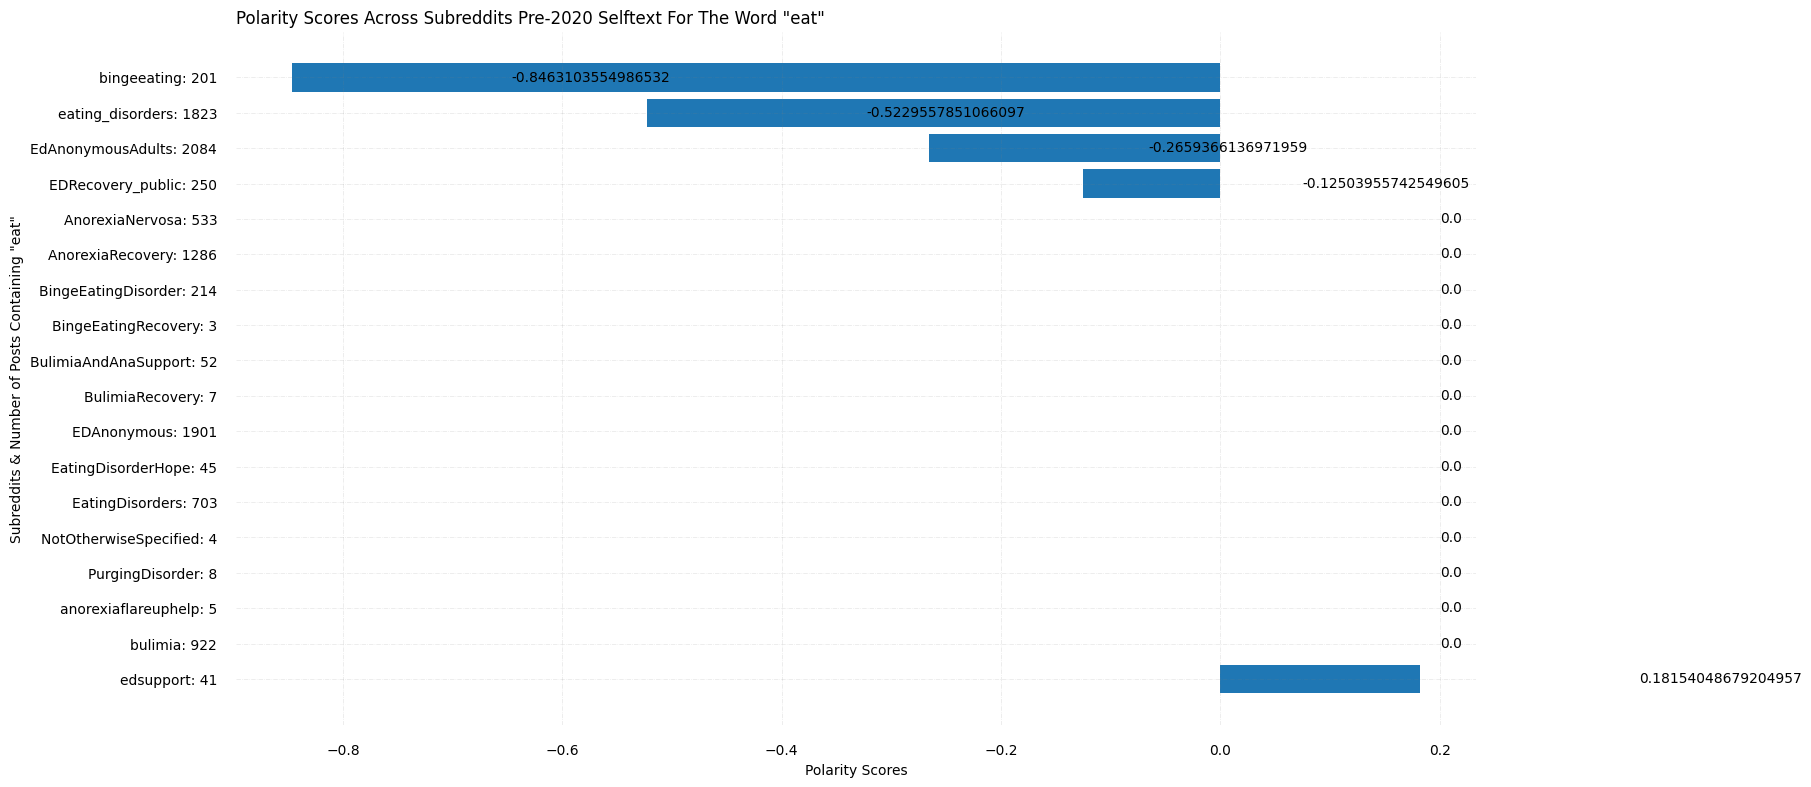

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


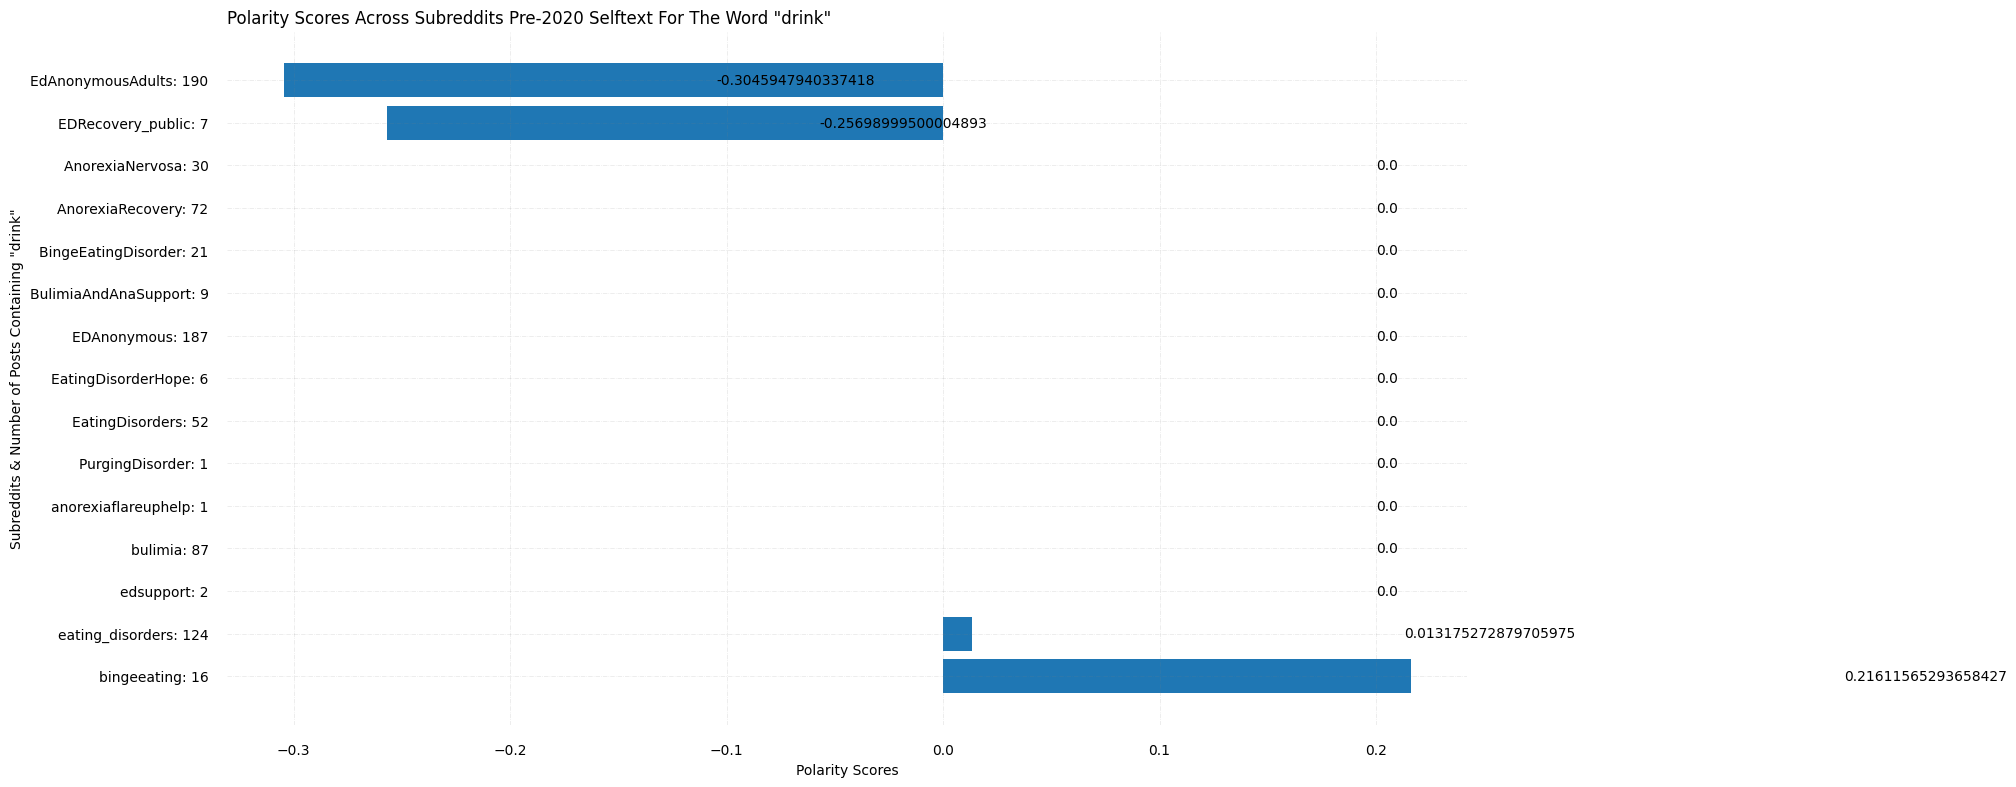

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


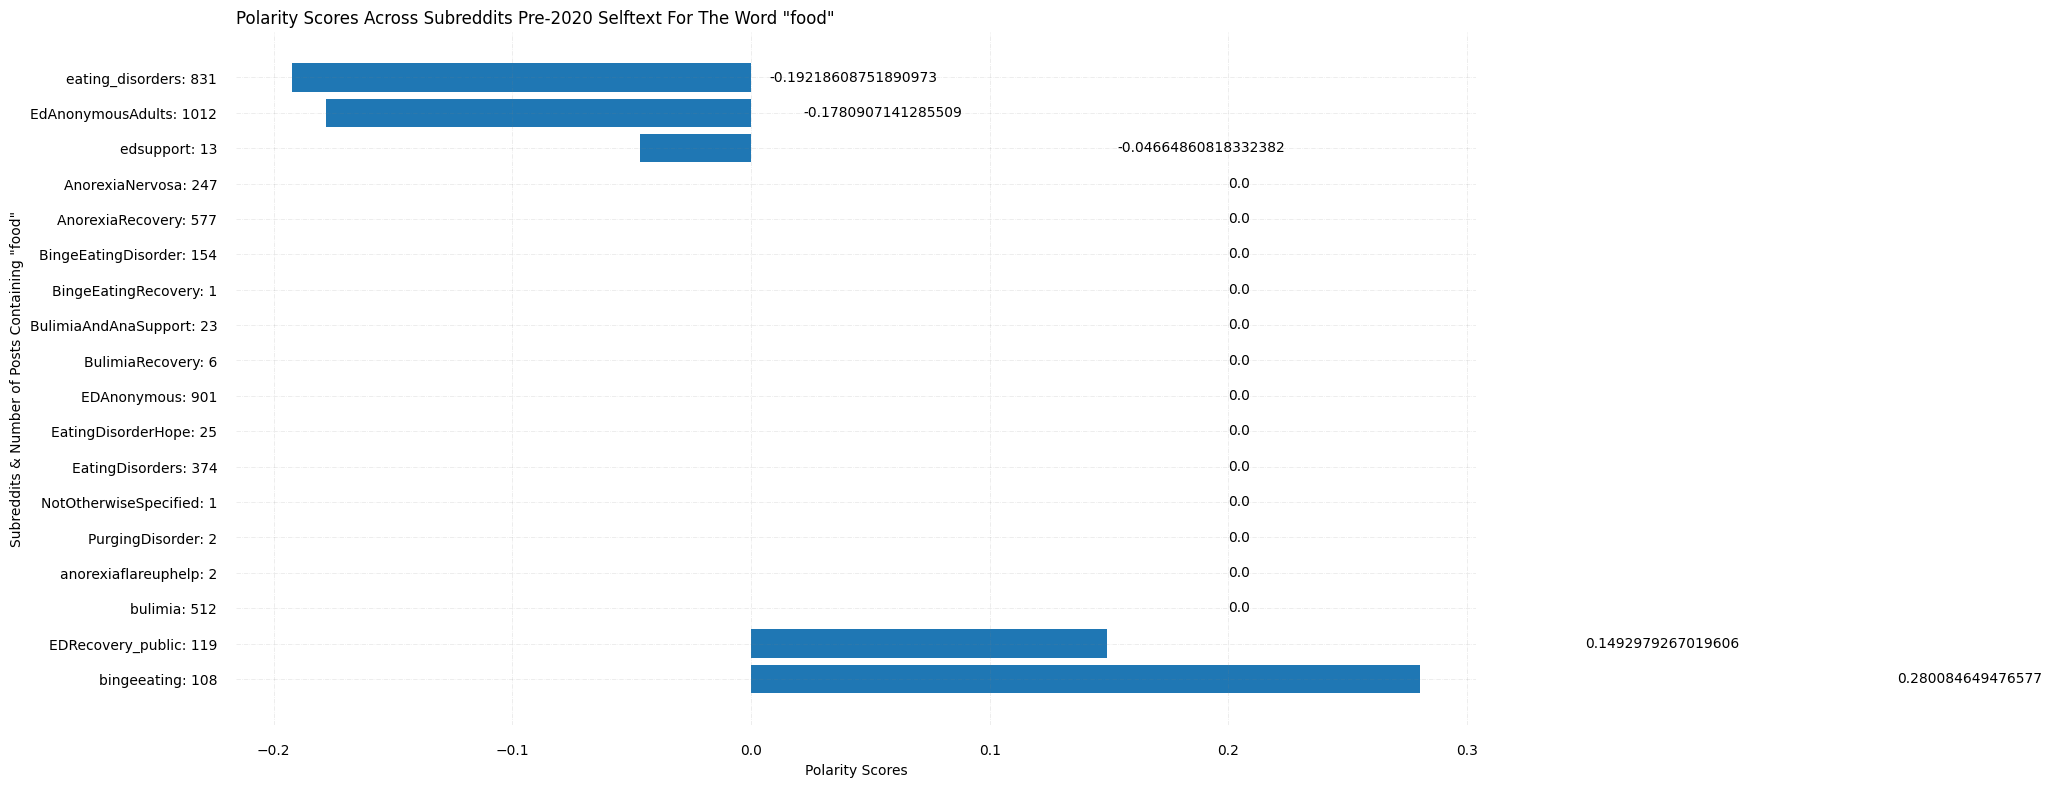

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


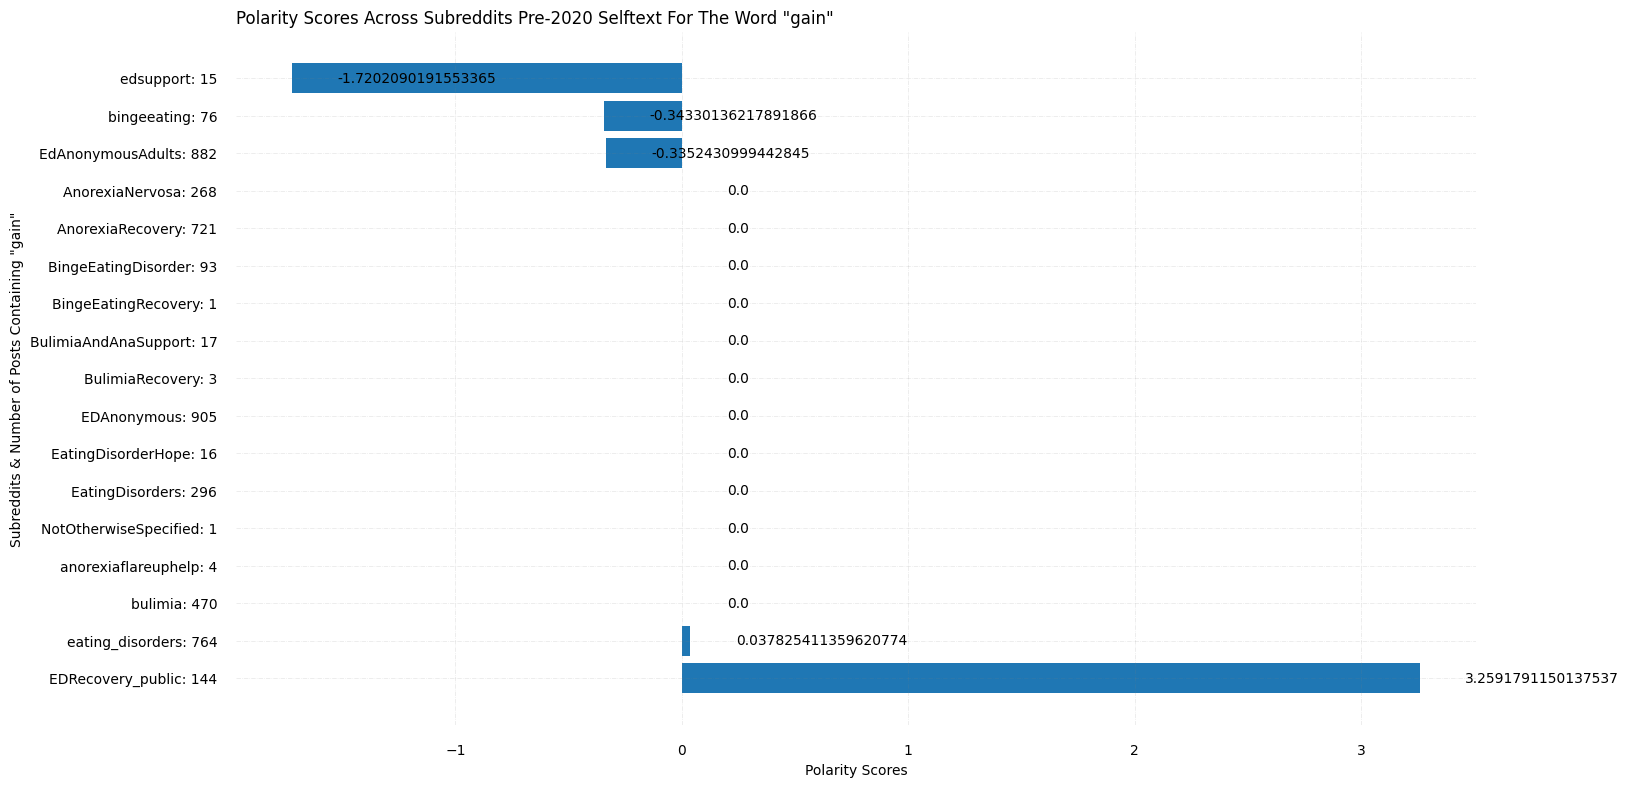

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


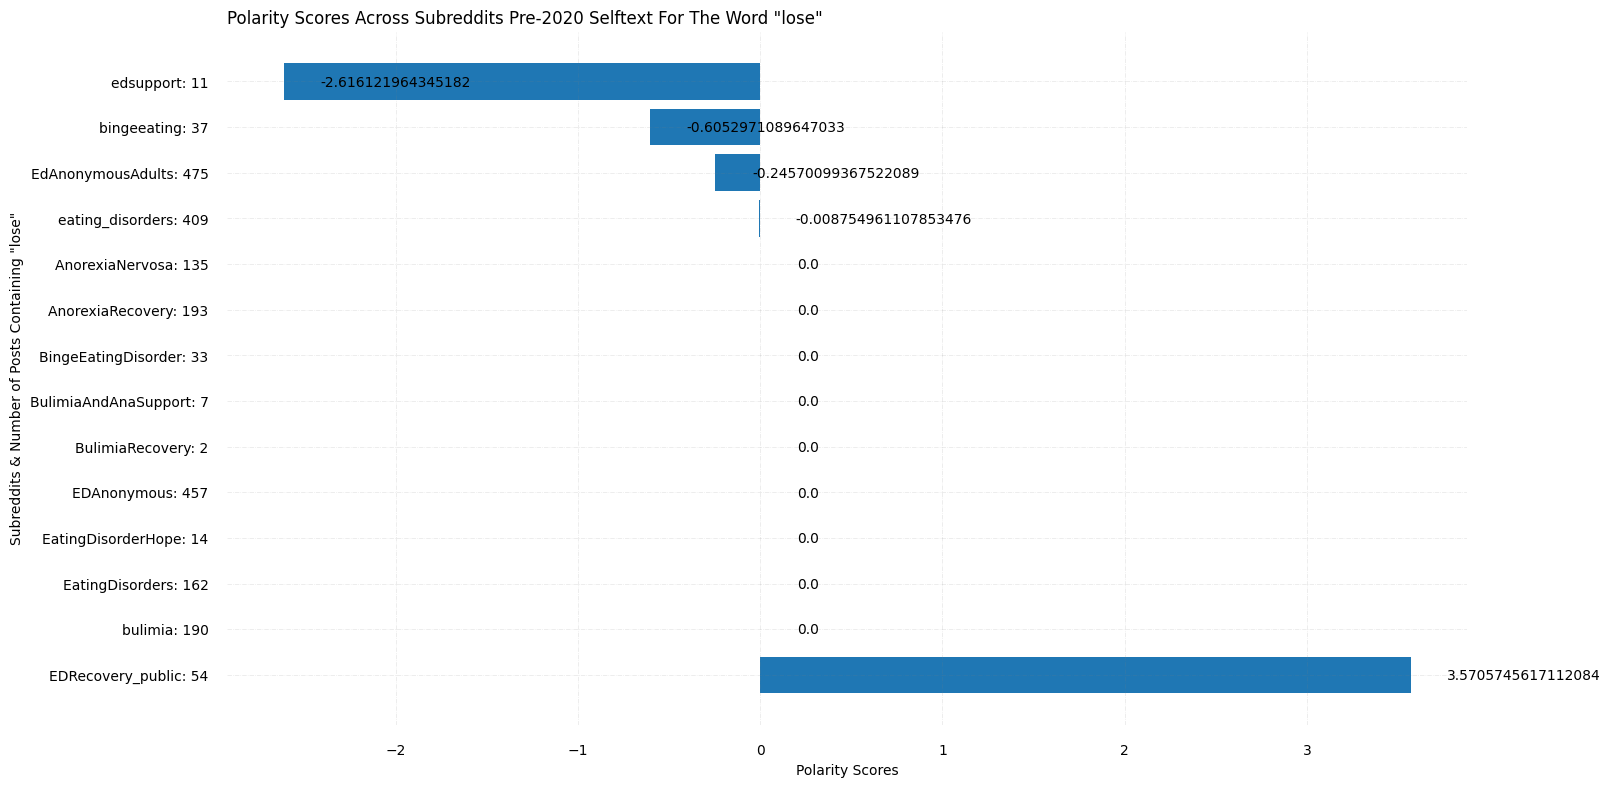

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


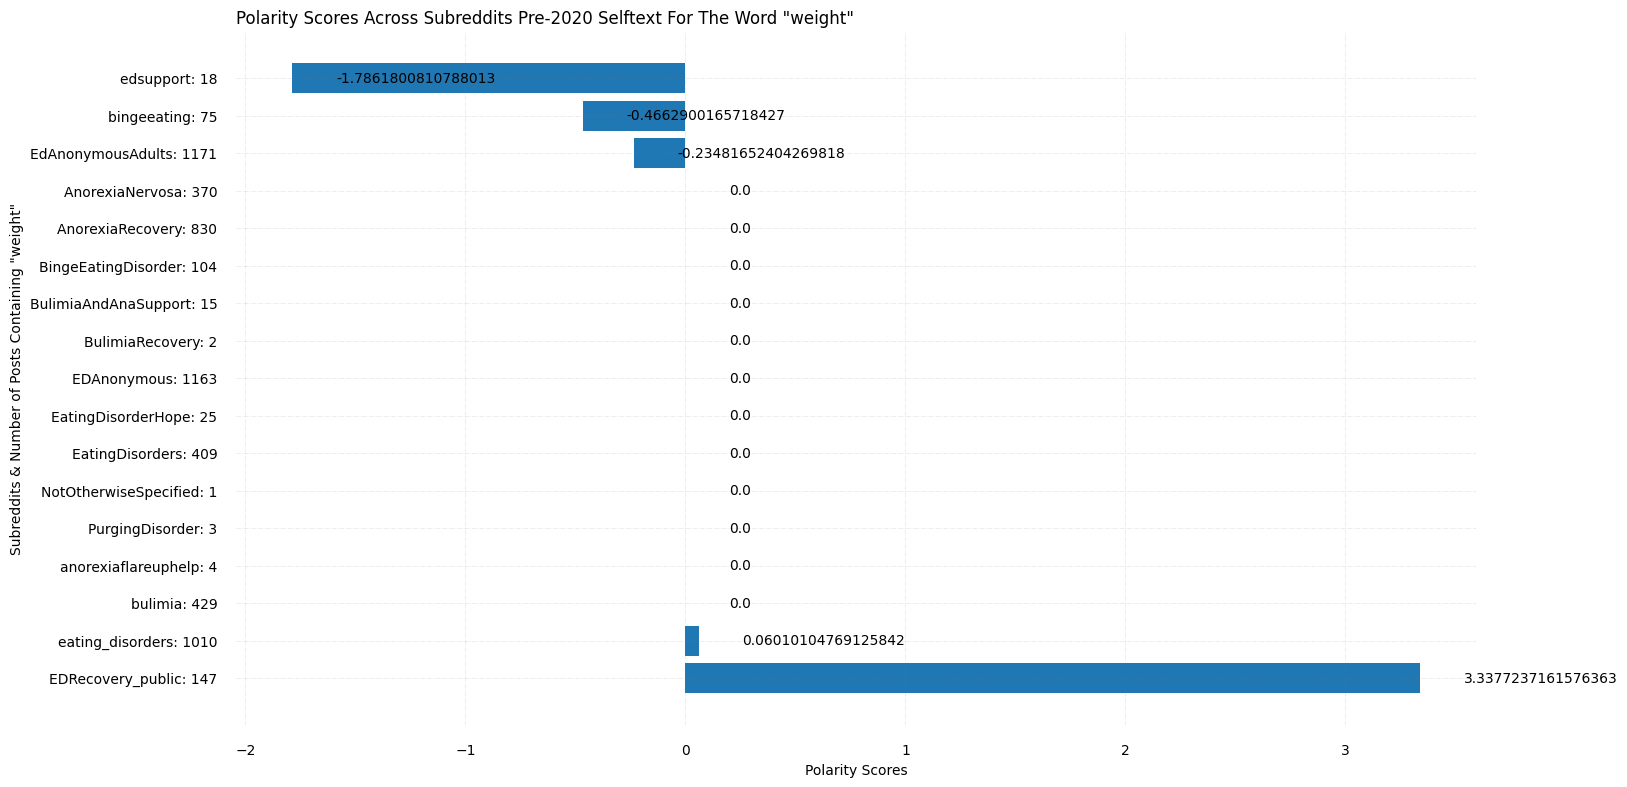

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


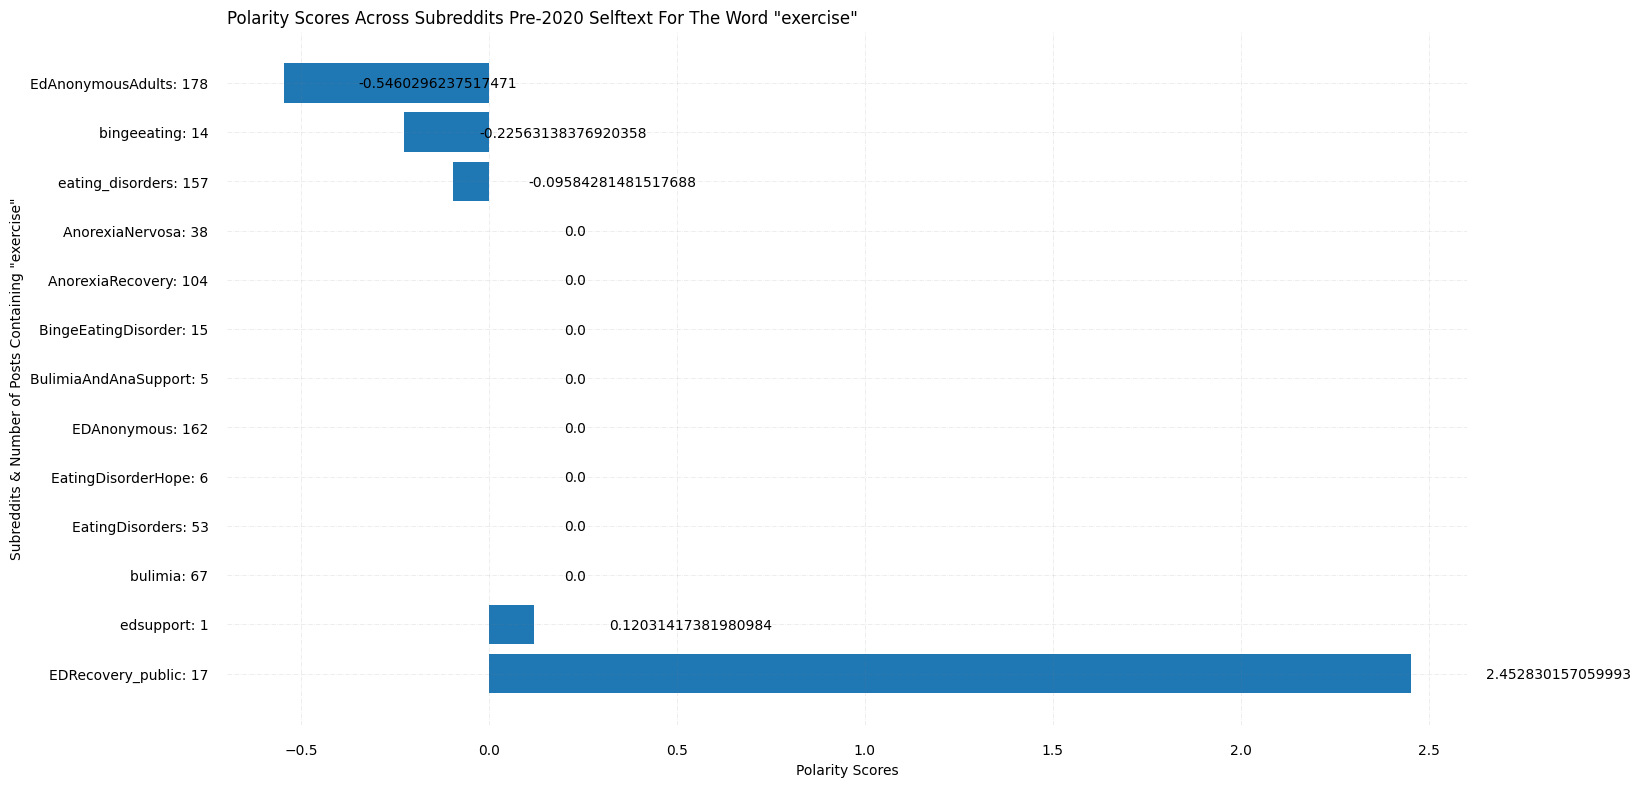

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


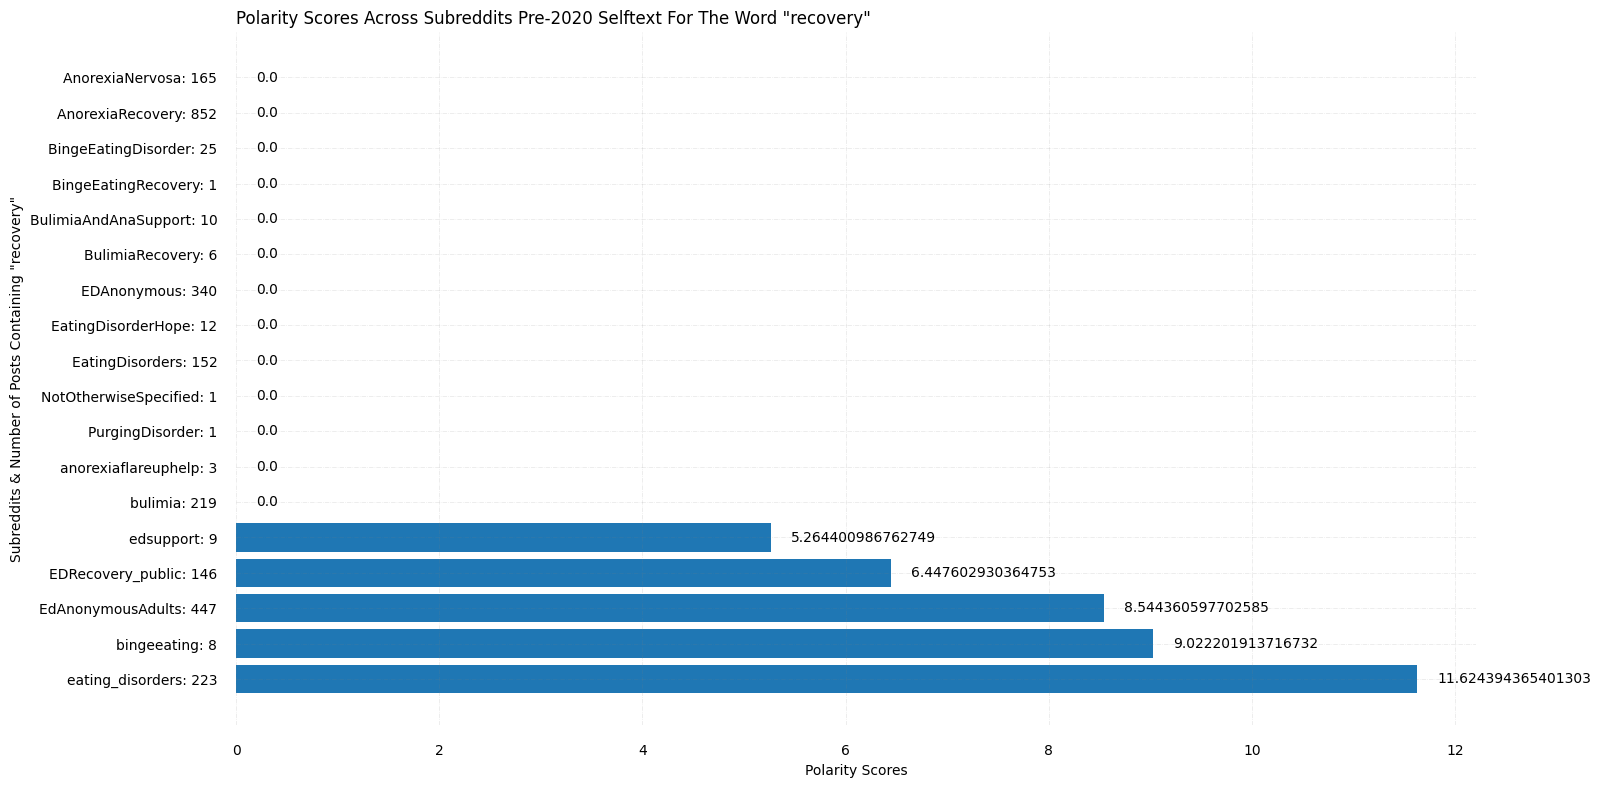

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


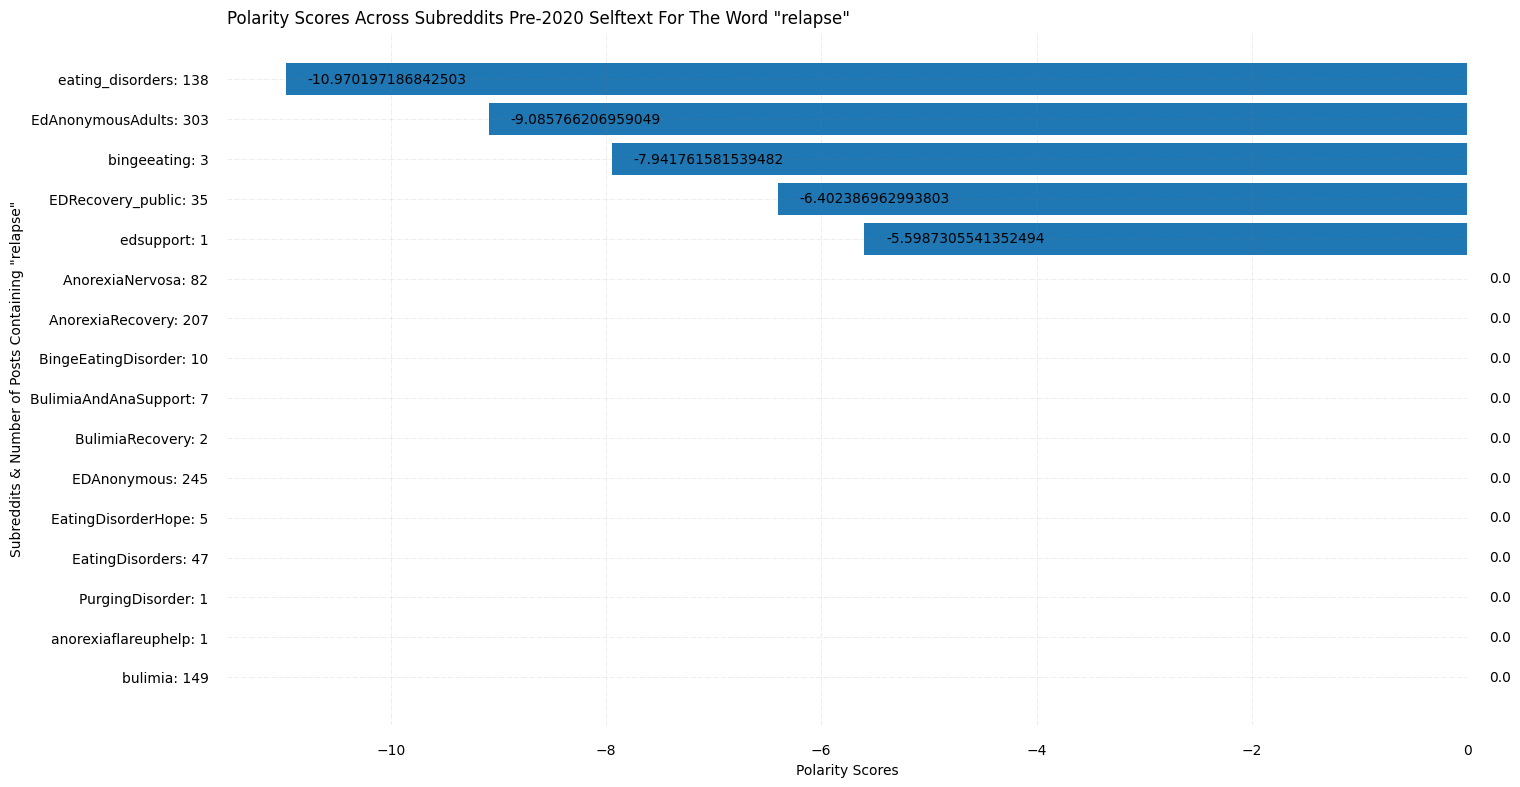

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


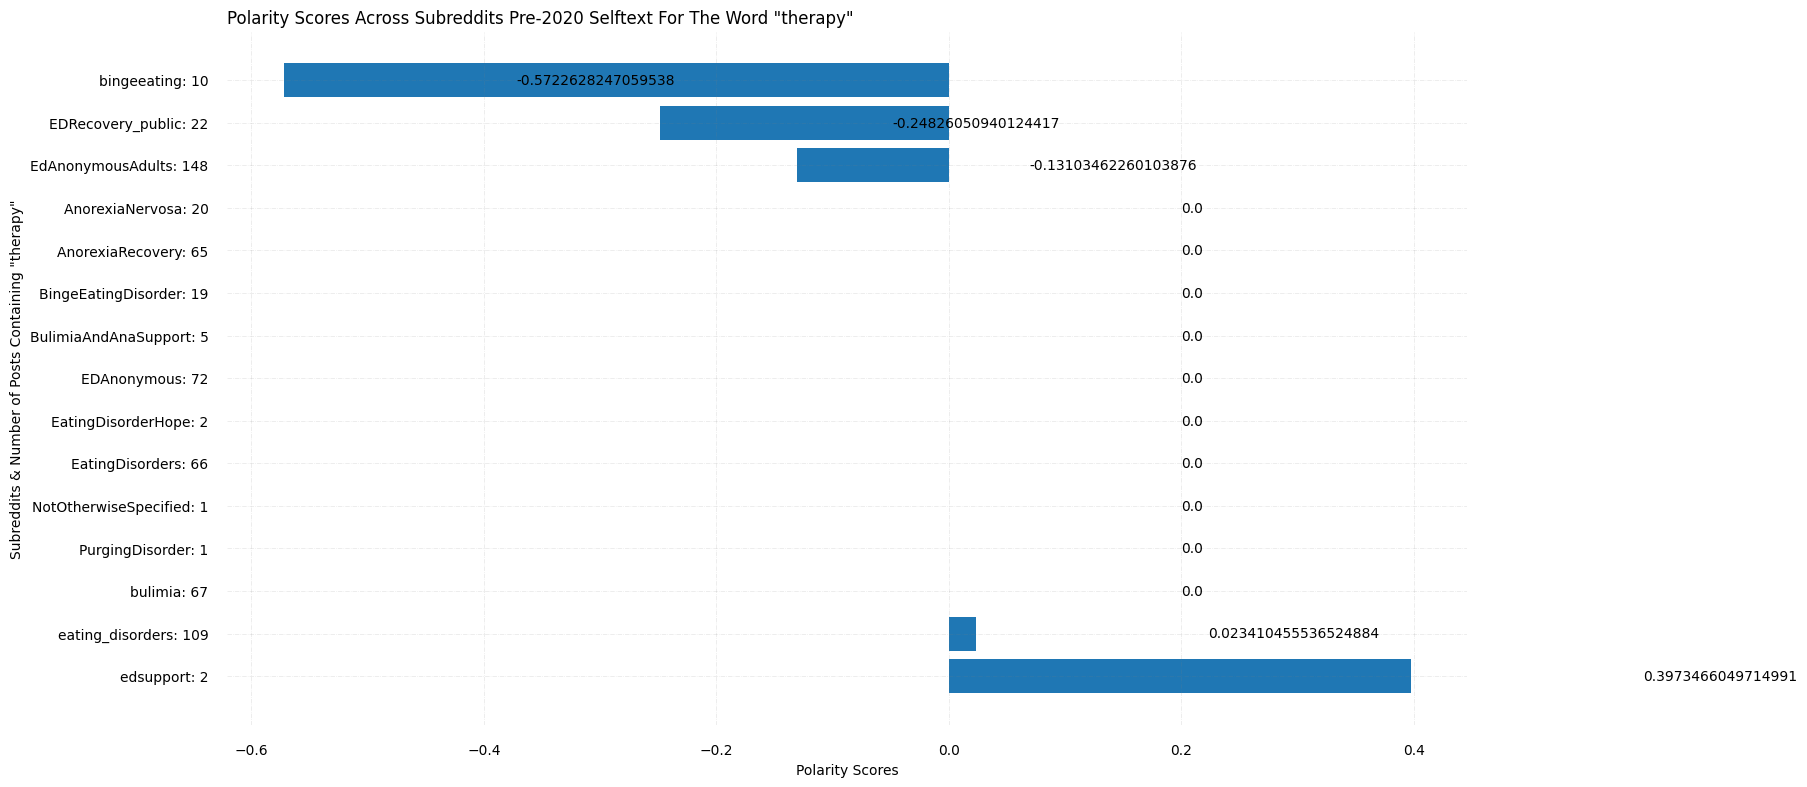

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


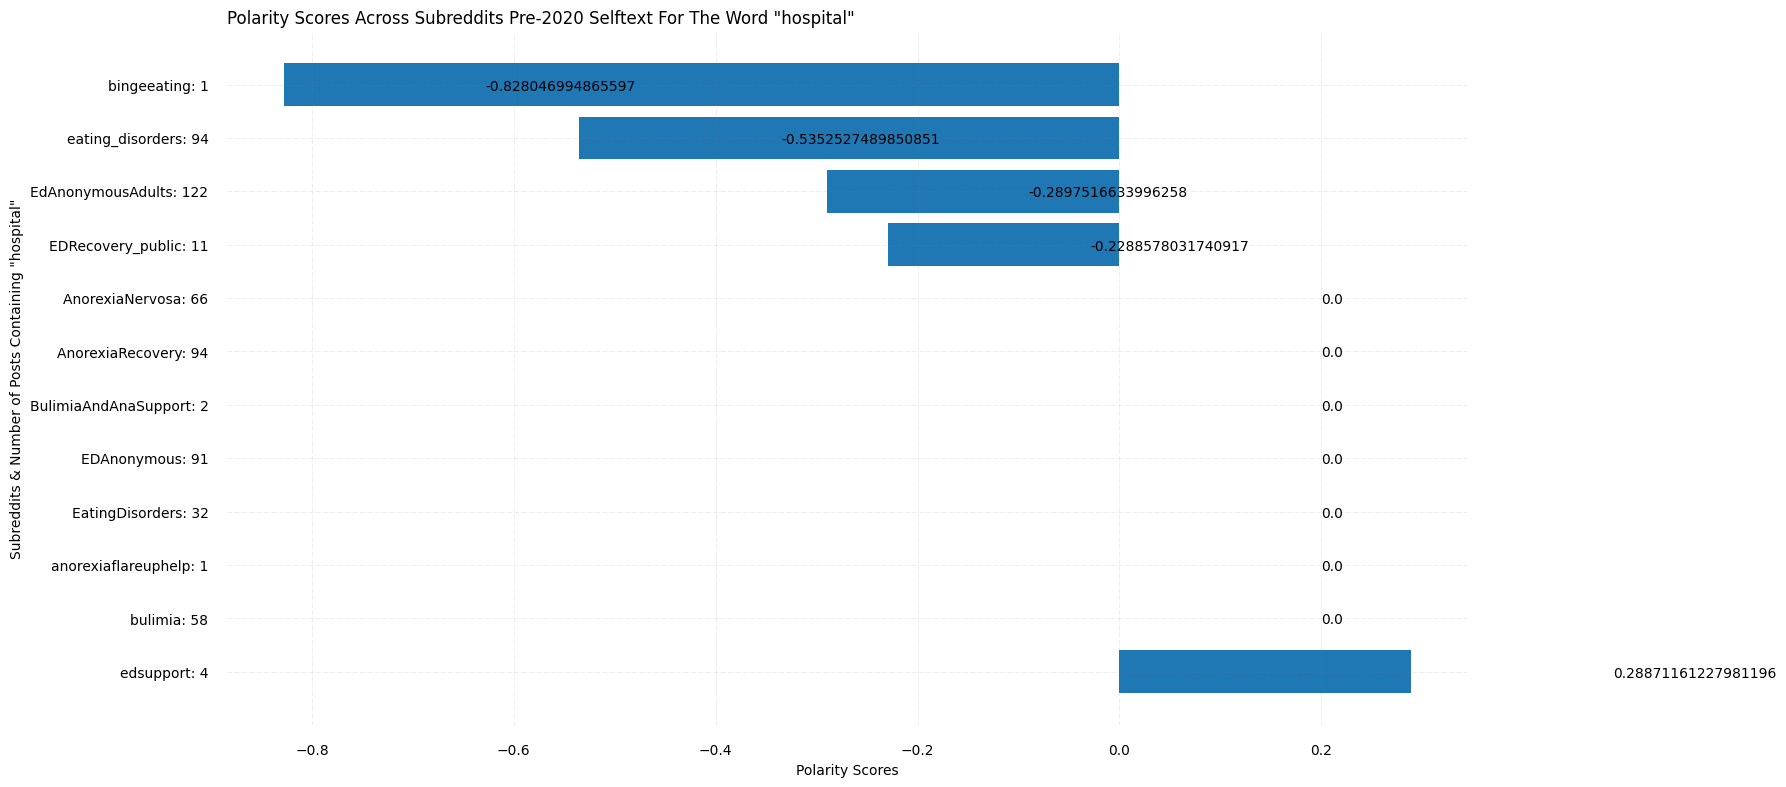

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


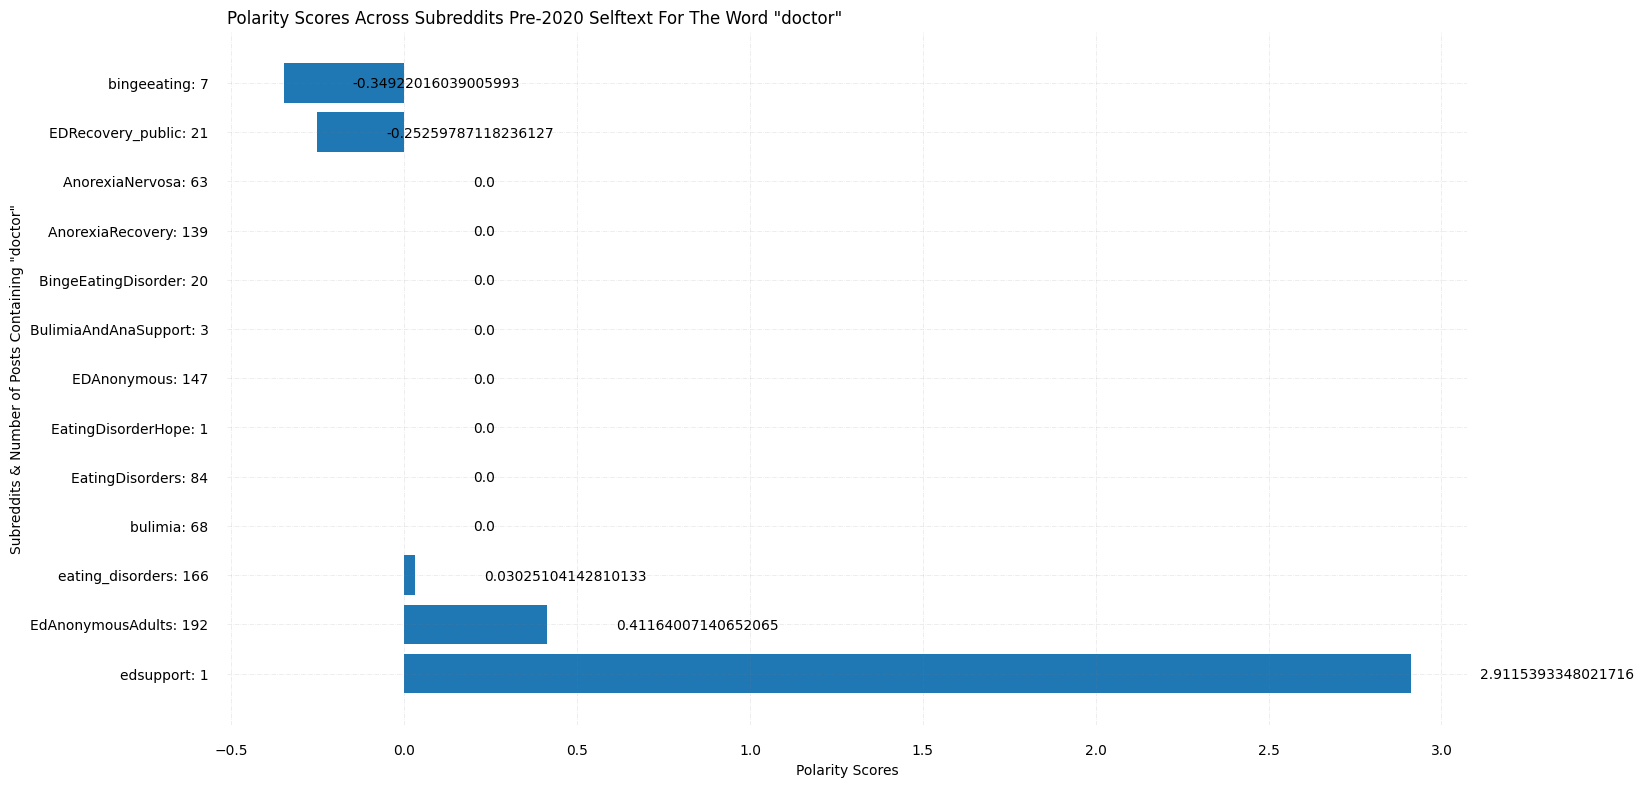

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


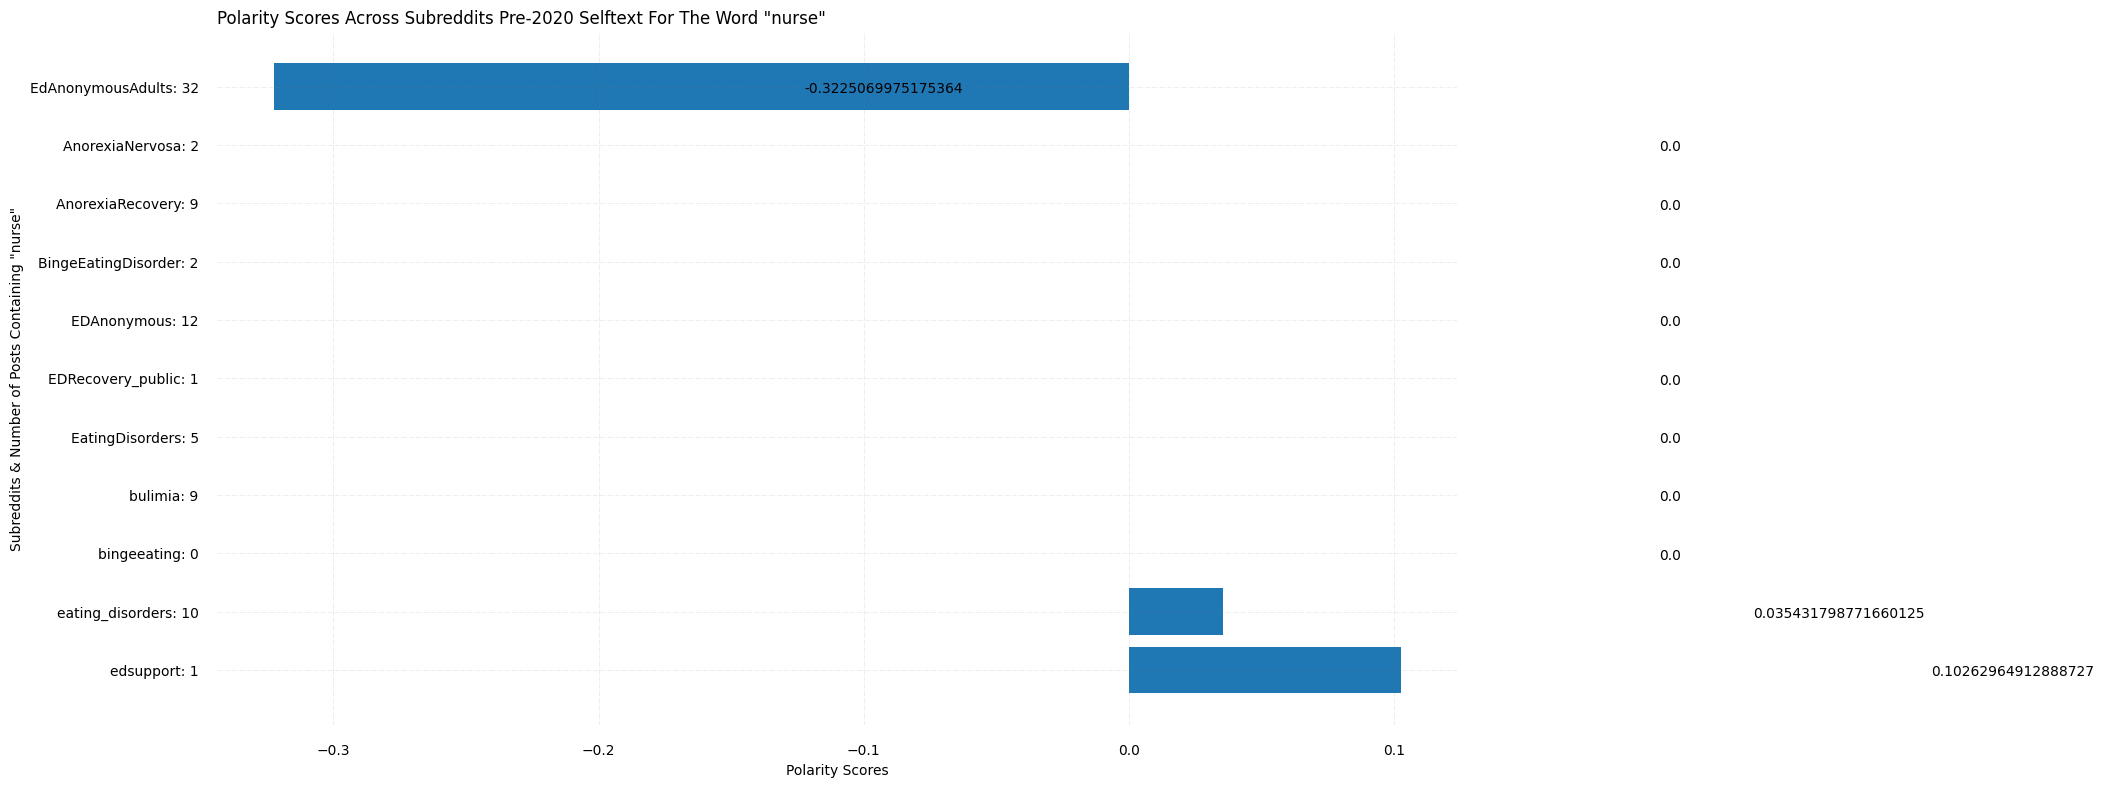

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


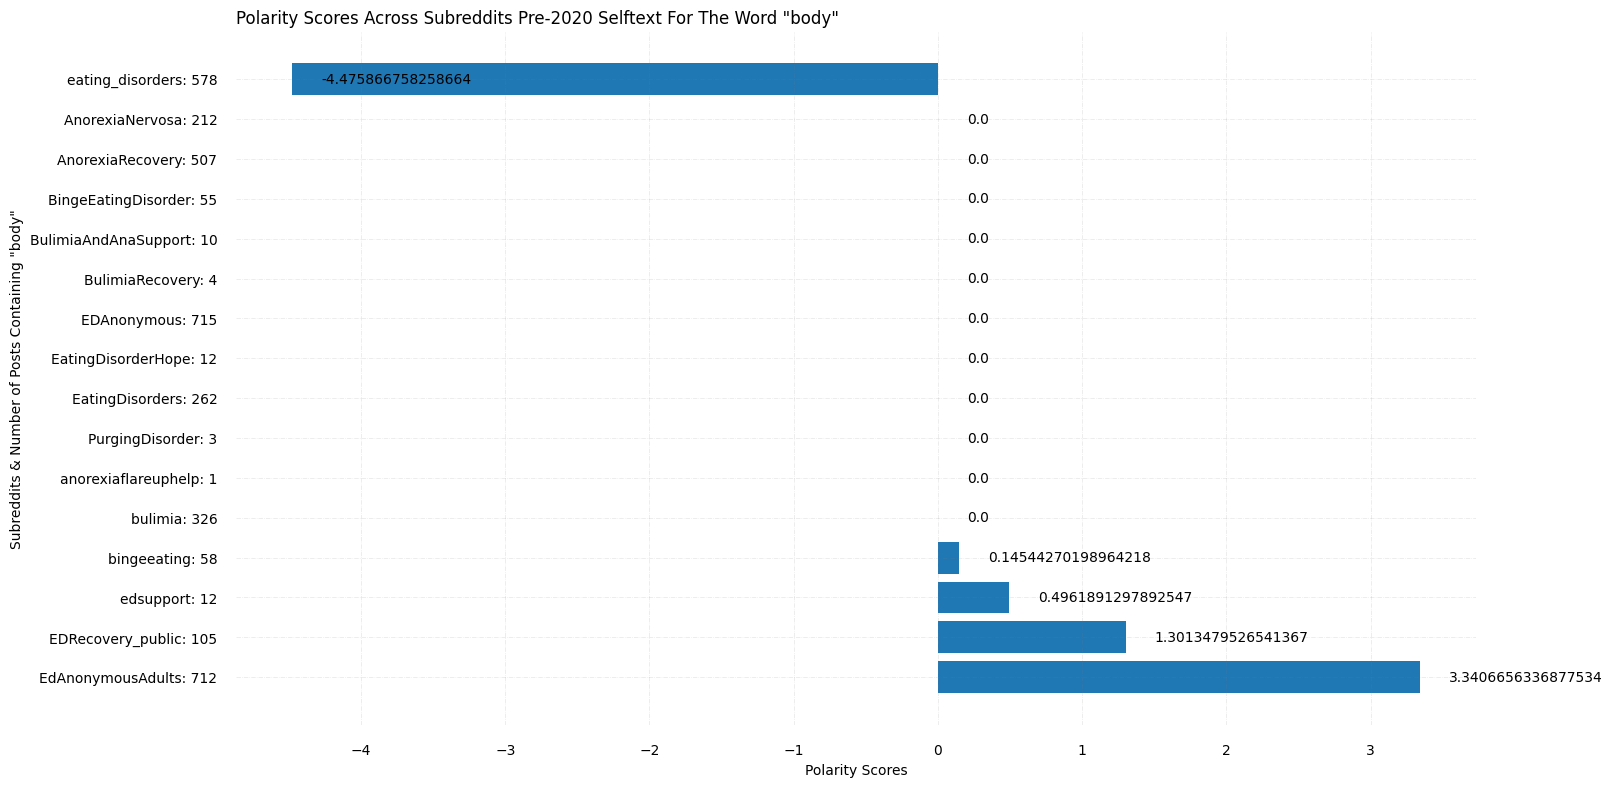

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


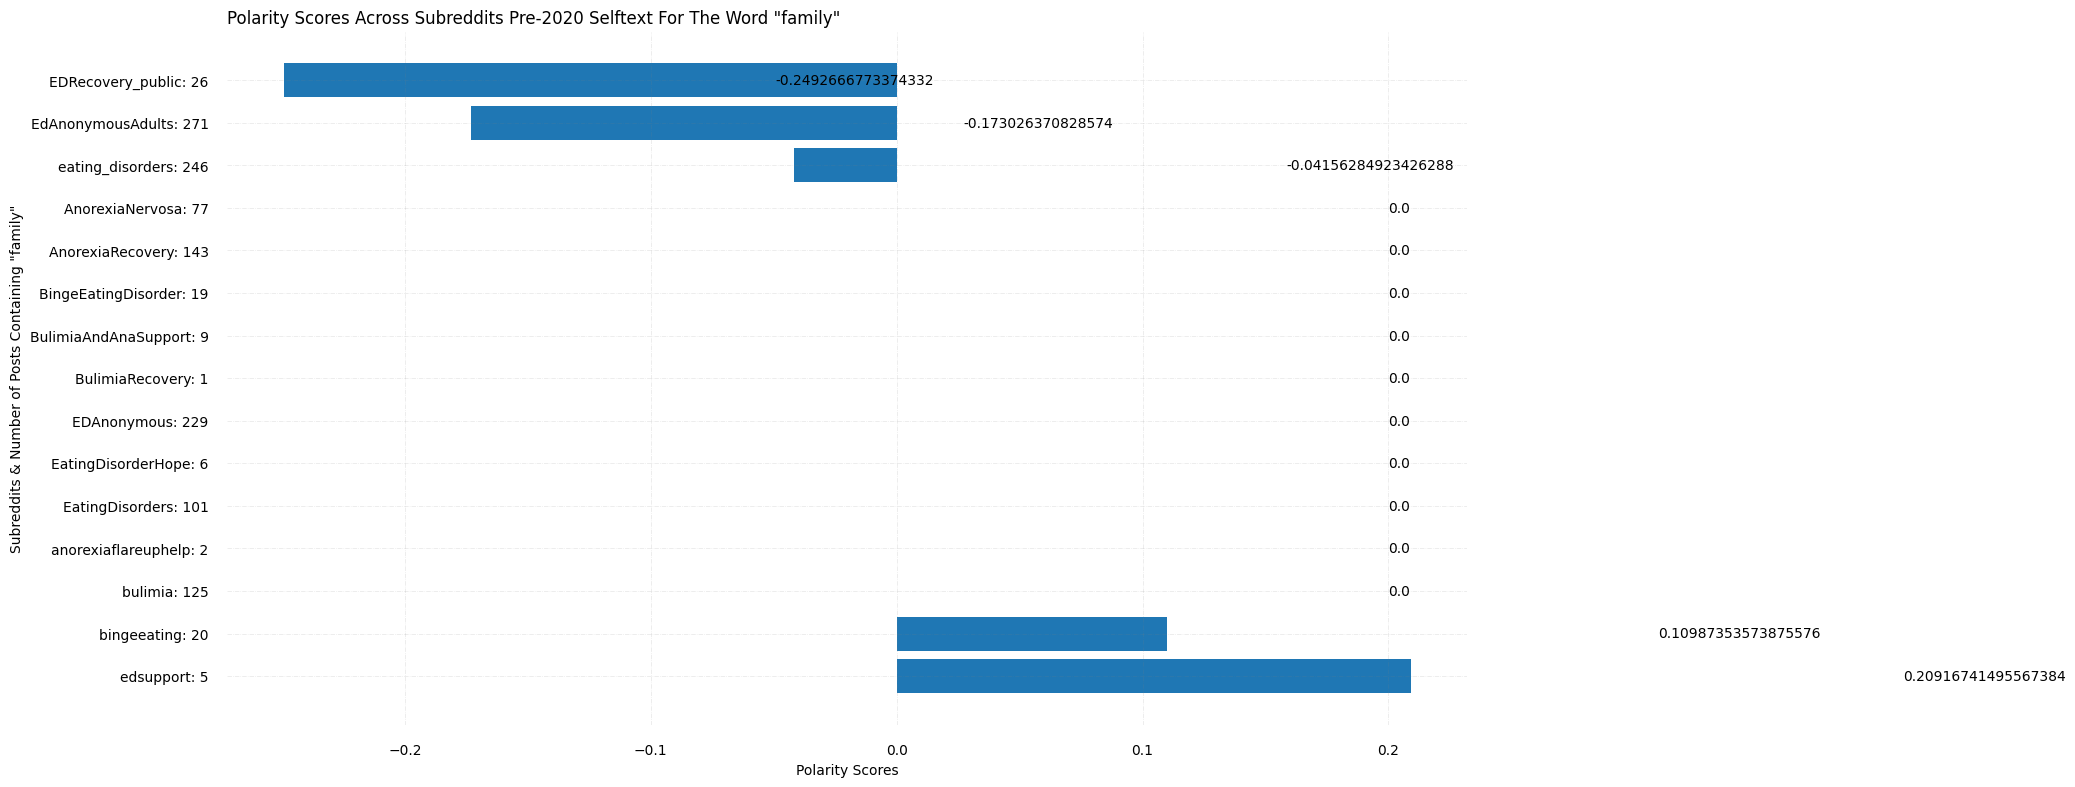

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


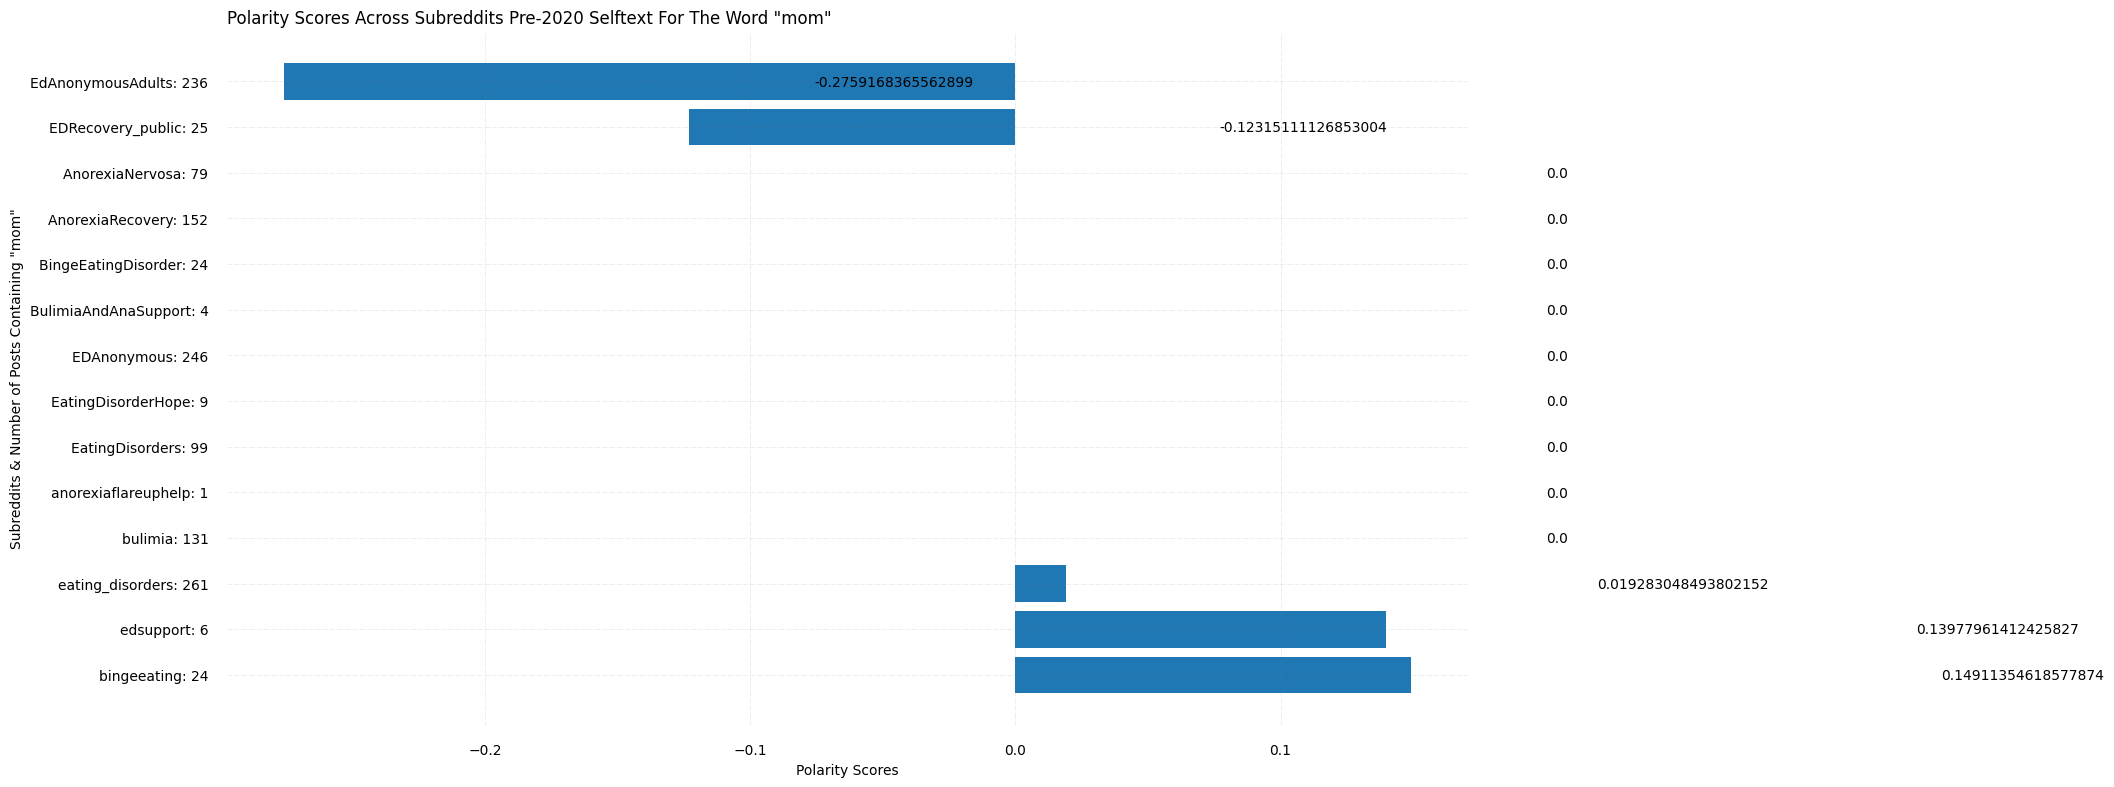

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/40744693.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


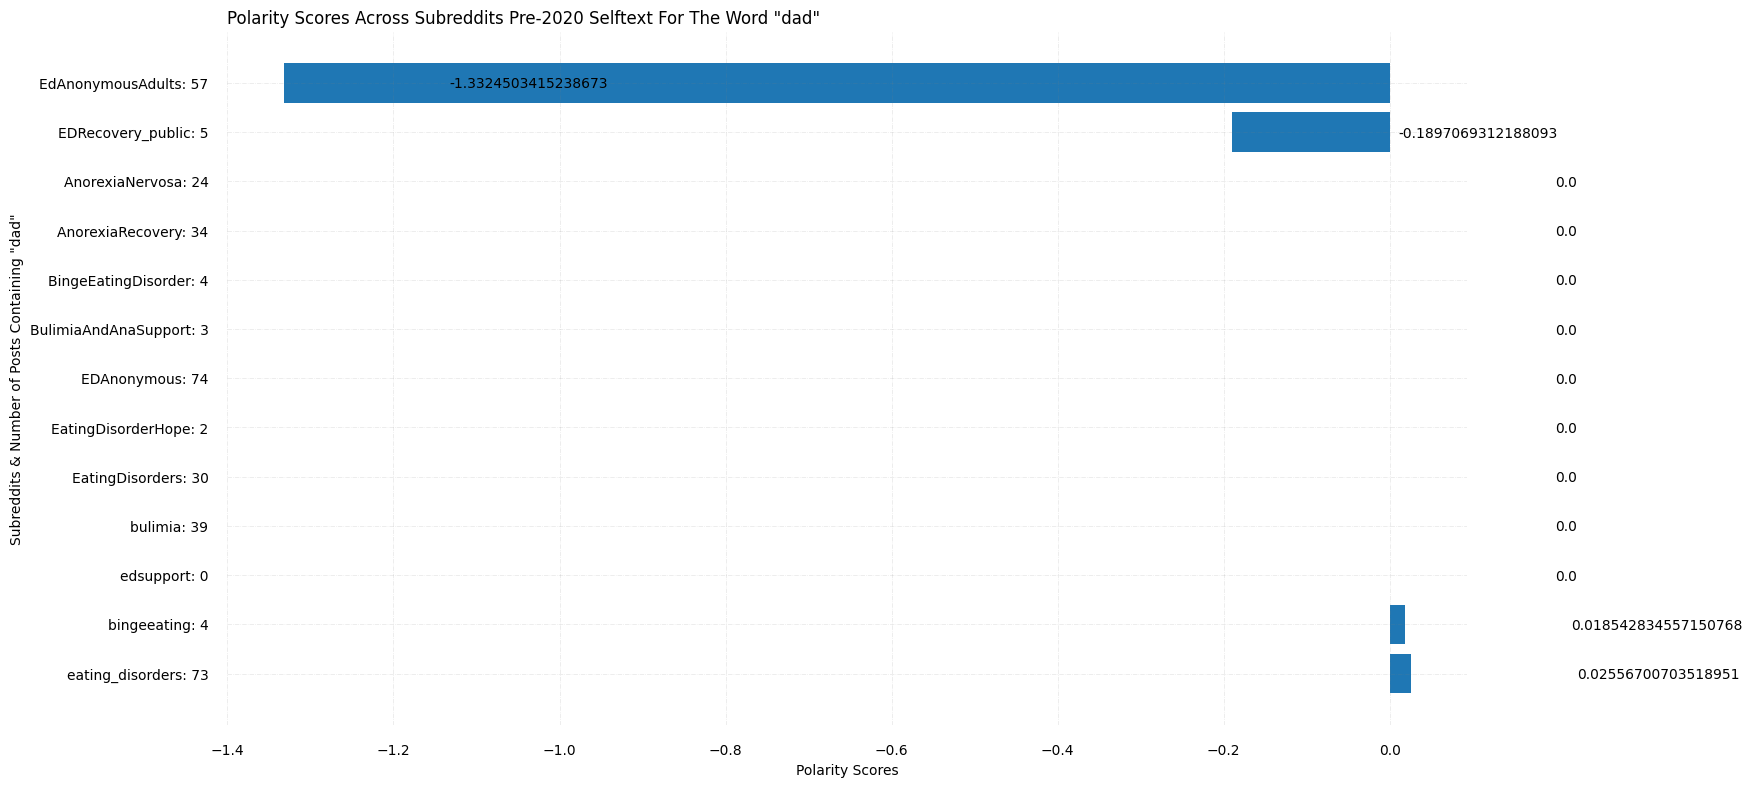

In [16]:
for keyword in keyword_scores.keys():
    subreddits = list(keyword_scores[keyword].keys())
    polarities = list(keyword_scores[keyword].values())

    
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(subreddits, polarities)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(i.get_width()),
                 fontsize = 10,
                 color ='black')

    # Add Plot Title
    ax.set_title(f'Polarity Scores Across Subreddits Pre-2020 Selftext For The Word "{keyword}"',
                 loc ='left', )
    plt.ylabel(f'Subreddits & Number of Posts Containing "{keyword}"')
    plt.xlabel("Polarity Scores")

    # Show Plot
    plt.show()


# Submission Polarities

### On submissions from subreddits with posts written pre-2020 (so submission polarities using word polarity scores calculated on pre-2020 selftext)

In [17]:
# average polarity scores

pre_2020_polarity_dfs = dict()
post_2020_polarity_dfs = dict()

for subreddit in subreddit_polarities.keys():
    try:
        pre_2020 = list()
        post_2020 = list()

        pre_2020_polarities = list()
        post_2020_polarities = list()

        print(subreddit)

        query = f"select id, selftext, created_utc from subreddit_submission_metadata where subreddit='{subreddit}';"
        df = pd.read_sql_query(text(query),con=engine.connect())

        df_ts = list(zip(df['id'].tolist(),df['created_utc'].tolist()))

        for i in df_ts:
            current = datetime.fromtimestamp(i[1])
            if current.year < 2020:
                pre_2020.append(i[0])
            elif current.year > 2020:
                post_2020.append(i[0])

        pre_2020_df = df[df['id'].isin(pre_2020)]
        post_2020_df = df[df['id'].isin(post_2020)]

        for sentence in pre_2020_df.values:
            preprocessed_sentence = lemmatized_preprocess(sentence[1])
            sentence_polarities = [subreddit_polarities[subreddit][word] for word in preprocessed_sentence if word in subreddit_polarities[subreddit].keys()]
            avg_polarities = np.average(sentence_polarities)
            pre_2020_polarities.append({'id':sentence[0], 'selftext':sentence[1],'sentence_polarity':avg_polarities})

        for sentence in post_2020_df.values:
            preprocessed_sentence = lemmatized_preprocess(sentence[1])
            sentence_polarities = [subreddit_polarities[subreddit][word] for word in preprocessed_sentence if word in subreddit_polarities[subreddit].keys()]
            avg_polarities = np.average(sentence_polarities)
            post_2020_polarities.append({'id':sentence[0], 'selftext':sentence[1], 'sentence_polarity':avg_polarities})

        pre_2020_polarity_dfs[subreddit] = pd.DataFrame.from_dict(pre_2020_polarities)
        post_2020_polarity_dfs[subreddit] = pd.DataFrame.from_dict(post_2020_polarities)
    except Exception as e:
        print(e)

bingeeating
eating_disorders


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EdAnonymousAdults


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EDRecovery_public
edsupport


In [18]:
pre_2020_polarity_dfs.keys()

dict_keys(['bingeeating', 'eating_disorders', 'EdAnonymousAdults', 'EDRecovery_public', 'edsupport'])

In [19]:
post_2020_polarity_dfs.keys()

dict_keys(['bingeeating', 'eating_disorders', 'EdAnonymousAdults', 'EDRecovery_public', 'edsupport'])

In [20]:
for subreddit in pre_2020_polarity_dfs.keys():
#     print(subreddit)
    sub = [subreddit for i in range(len(pre_2020_polarity_dfs[subreddit]))]
    pre_2020_polarity_dfs[subreddit]['subreddit'] = sub

In [21]:
pre_2020_all_v1 = pd.concat([pre_2020_polarity_dfs[subreddit] for subreddit in pre_2020_polarity_dfs.keys()])

In [22]:
pre_2020_all_v1.sort_values(by='sentence_polarity')

id                                           selftext  \
136  dw3erf  So I “recovered” - was out of inpatient, maint...   
75   cm7wa9  ...I broke my fast. And ate when I didn’t need...   
27   dmynju                   A YouTuber has really helped me.   
14   efsa3y  Just need to vent because I hate myself so muc...   
38   df3nca  I’ve binged today after nearly a week and day ...   
..      ...                                                ...   
335  b7cflr  **Selfie Post**\n\n*NSFW*\n\nPost your newest ...   
415  aral63  **Selfie Post**\n\n*NSFW*\n\n\nPost your newes...   
500  afb1k0  **Selfie Post**\n\n*NSFW*\n\n\nPost your newes...   
267  cjkmxe                                                  🙍   
432  aonx7a                                                🤔🤔🤔   

     sentence_polarity          subreddit  
136          -1.722811   eating_disorders  
75           -1.356115        bingeeating  
27           -1.250916        bingeeating  
14           -1.046373   eating_disorders  
38           -1.013567        bingeeating  
..                 ...                ...  
335           3.178035  EdAnonymousAdults  
415           3.178035  EdAnonymousAdults  
500           3.178035  EdAnonymousAdults  
267                NaN  EdAnonymousAdults  
432                NaN  EdAnonymousAdults  

[1278 rows x 4 columns]

In [23]:
for subreddit in post_2020_polarity_dfs.keys():
#     print(subreddit)
    sub = [subreddit for i in range(len(post_2020_polarity_dfs[subreddit]))]
    post_2020_polarity_dfs[subreddit]['subreddit'] = sub

In [24]:
post_2020_all_v1 = pd.concat([post_2020_polarity_dfs[subreddit] for subreddit in post_2020_polarity_dfs.keys()])

In [25]:
post_2020_all_v1.sort_values(by='sentence_polarity')

subreddit      id  \
781    eating_disorders  ln2kow   
657    eating_disorders  mhixx2   
622   EdAnonymousAdults  p4z4x1   
1515  EdAnonymousAdults  l26zpk   
950   EdAnonymousAdults  nkbe4y   
...                 ...     ...   
1609  EdAnonymousAdults  ko87d5   
142   EDRecovery_public  mkow6l   
662    eating_disorders  mfholh   
845    eating_disorders  l7wewy   
997   EdAnonymousAdults  nckeed   

                                               selftext  sentence_polarity  
781   I HATE FAMILY DINNERS! \n\nThat's it. Enough s...          -2.724178  
657                   Just feeling ugly I hate my teeth          -2.467840  
622   [I hate myself](https://i.imgur.com/CHKdkxS.jp...          -2.387607  
1515  Holy shit I just realized that I’ve relapsed a...          -2.280557  
950     Bulimic currently relapsing, freaked out, help!          -1.918875  
...                                                 ...                ...  
1609                                  Happy new year...           3.359039  
142                Can I get some emotional support? ❤️           3.602464  
662   Does anyone know of any good places for recove...           3.658864  
845                     FUUUUUUUUUUUUUUUUUUUUUUUUUUUUCK                NaN  
997                                              whoops                NaN  

[2751 rows x 4 columns]

# Keyword Comparision (Post-2020)

In [26]:
lemmatized_normalized_dir = "./polarities/post_2020_lemmatized_normalized"

In [27]:
subreddits = list()

In [28]:
subreddit_polarities = dict()
for subreddit in os.listdir(lemmatized_normalized_dir):
    if subreddit.split('.')[-1] == 'json':
        with open(os.path.join(lemmatized_normalized_dir,subreddit)) as f:
            subreddit_polarities[subreddit.split('_standardized')[0]] = json.load(f)
            subreddits.append(subreddit.split('_standardized')[0])

In [29]:
subreddit_polarities.keys()

dict_keys(['AnorexiaRecovery', 'eating_disorders', 'EdAnonymousAdults', 'bulimia', 'BulimiaRecovery', 'EDRecovery_public', 'BingeEatingDisorder', 'EatingDisorders', 'anorexiaflareuphelp', 'PurgingDisorder', 'AnorexiaNervosa', 'BulimiaAndAnaSupport', 'EDAnonymous', 'NotOtherwiseSpecified'])

In [30]:
keywords = [
    "eat",
    "drink",
    "food",
    "gain", 
    "lose",
    "weight", 
    "exercise", 
    "recovery",
    "relapse",
    "therapy",
    "hospital",
    "doctor",
    "nurse",
    "body",
    "family",
    "mom",
    "dad"
]

In [31]:
keyword_scores = dict()

In [32]:
for keyword in keywords:
    keyword_scores[keyword] = dict()
    query = f"select subreddit, cast(count(*) as varchar) as num_submissions_with_word from subreddit_submission_metadata where selftext like '%{keyword}%' group by subreddit;"
    num_submissions_with_word = pd.read_sql_query(text(query),con=engine.connect())
    
    subreddit_tuples = list(num_submissions_with_word.itertuples(index=False, name=None))
    
    for subreddit in subreddits:
        if subreddit not in num_submissions_with_word['subreddit'].tolist():
            subreddit_tuples.append((subreddit,'0'))
            
#     print('\n',subreddit_tuples,'\n')
    
    sub_list = list()
        
    for tup in subreddit_tuples:
        sub_list.append(': '.join(tup))
        
#     print('\n',sub_list,'\n')
    
#     combo = [": ".join(item) for item in zip(subreddits,sub_list)]

    for subreddit in sub_list:
        if subreddit.split(': ')[0] in subreddit_polarities:
            if keyword in subreddit_polarities[subreddit.split(': ')[0]].keys():
                keyword_scores[keyword][subreddit] = subreddit_polarities[subreddit.split(': ')[0]][keyword]
            else:
                keyword_scores[keyword][subreddit] = 0
        else:
            keyword_scores[keyword][subreddit] = 0
    #             print(keyword, subreddit)
    #             q = f"select selftext from subreddit_submission_metadata where subreddit='{subreddit.split(': ')[0]}' and selftext like '% {keyword} %';"
    #             d = pd.read_sql_query(text(q),con=engine.connect())
    #             print(d['selftext'].tolist())

In [33]:
for keyword in keyword_scores:
#     keyword_scores[keyword].pop('selftext')
    keyword_scores[keyword] = dict(sorted(keyword_scores[keyword].items(), key=lambda item: item[1]))

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


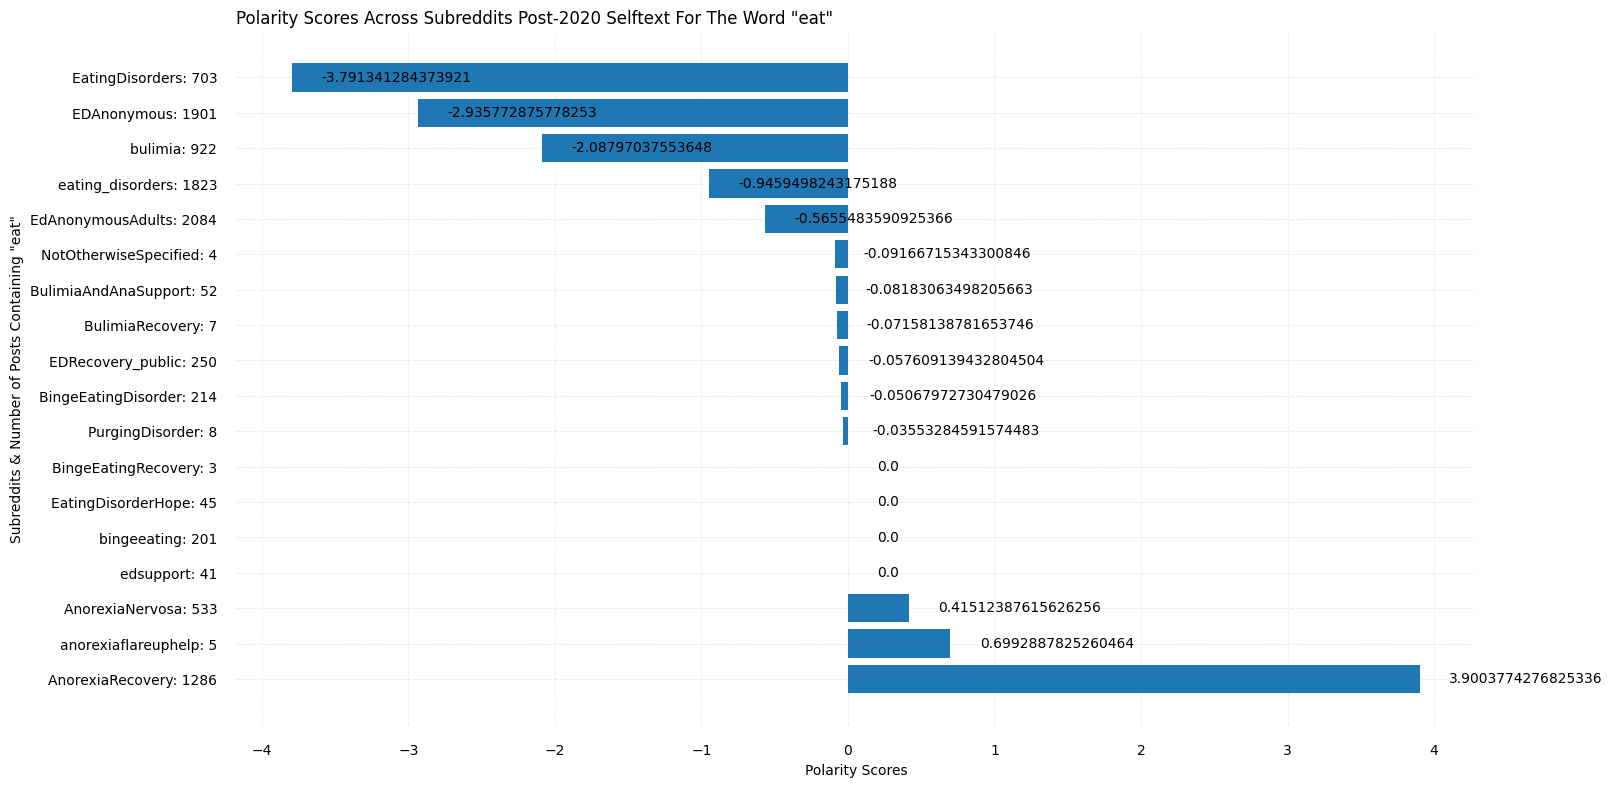

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


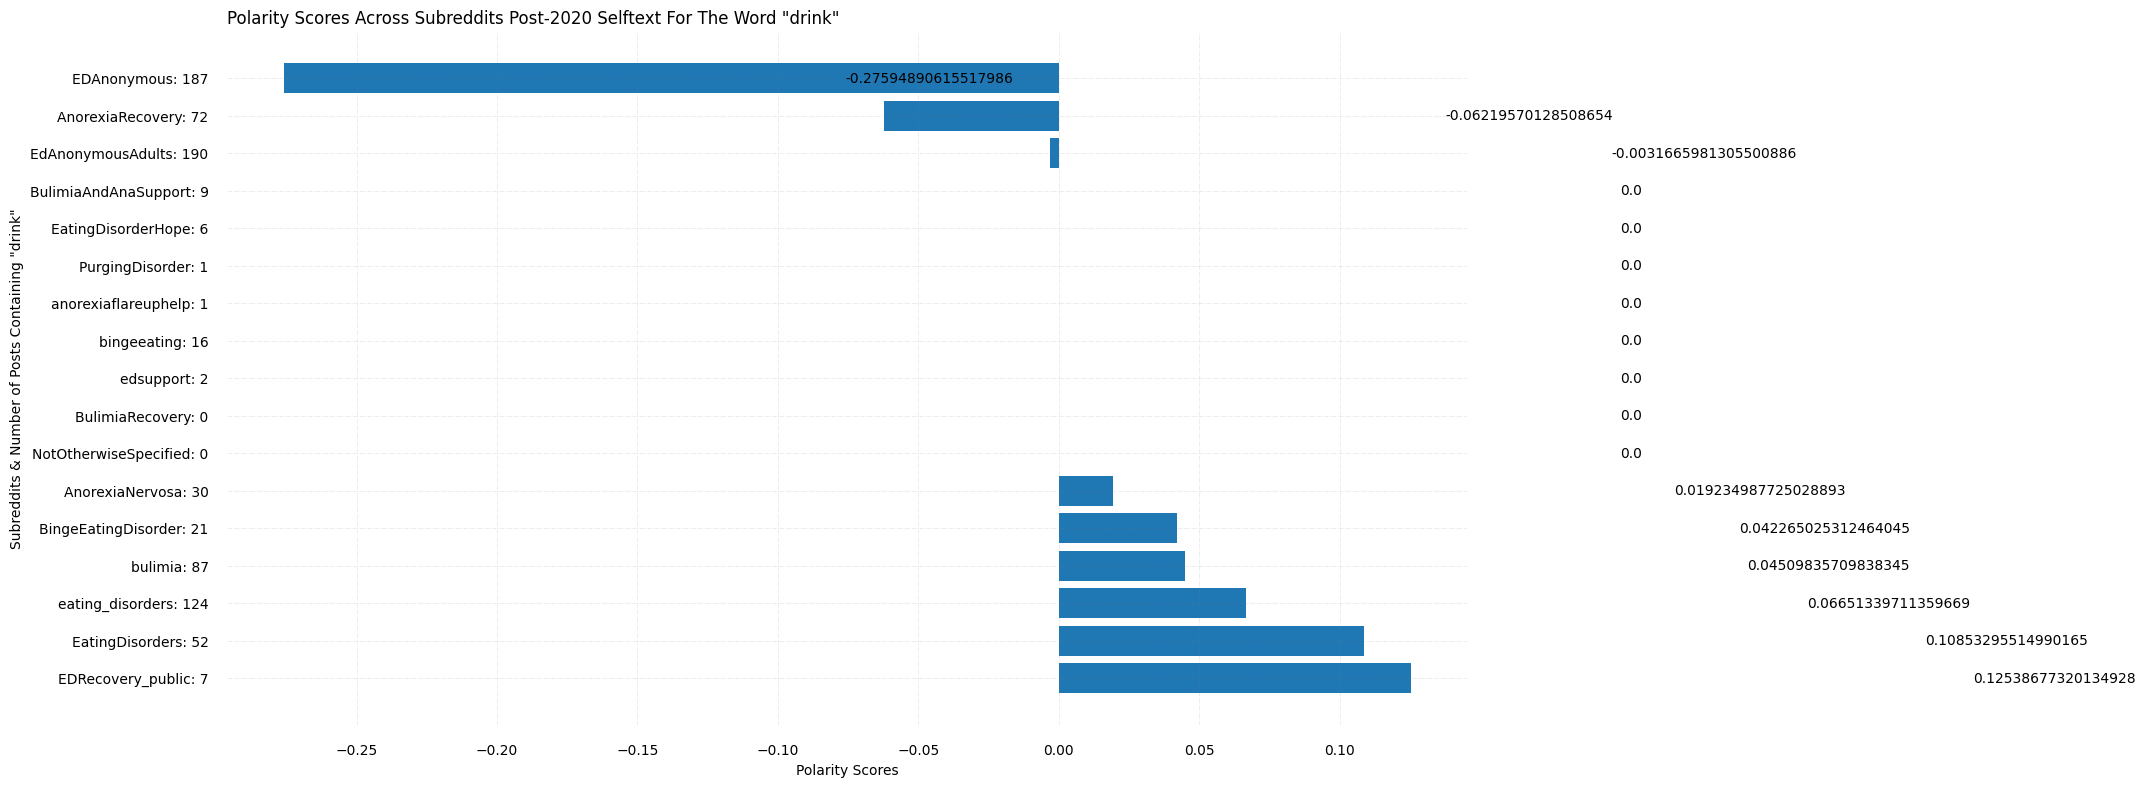

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


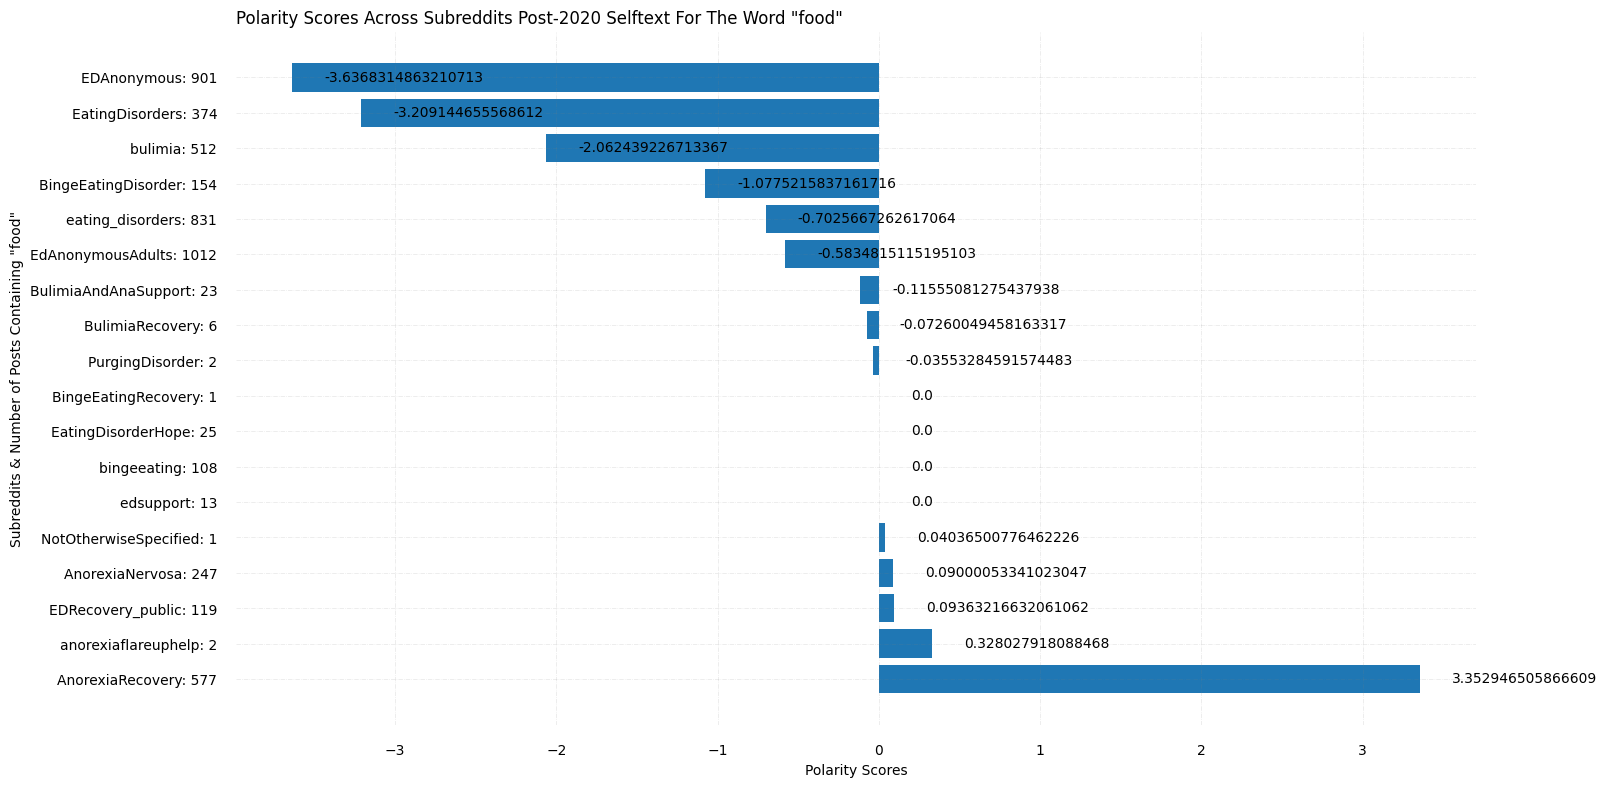

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


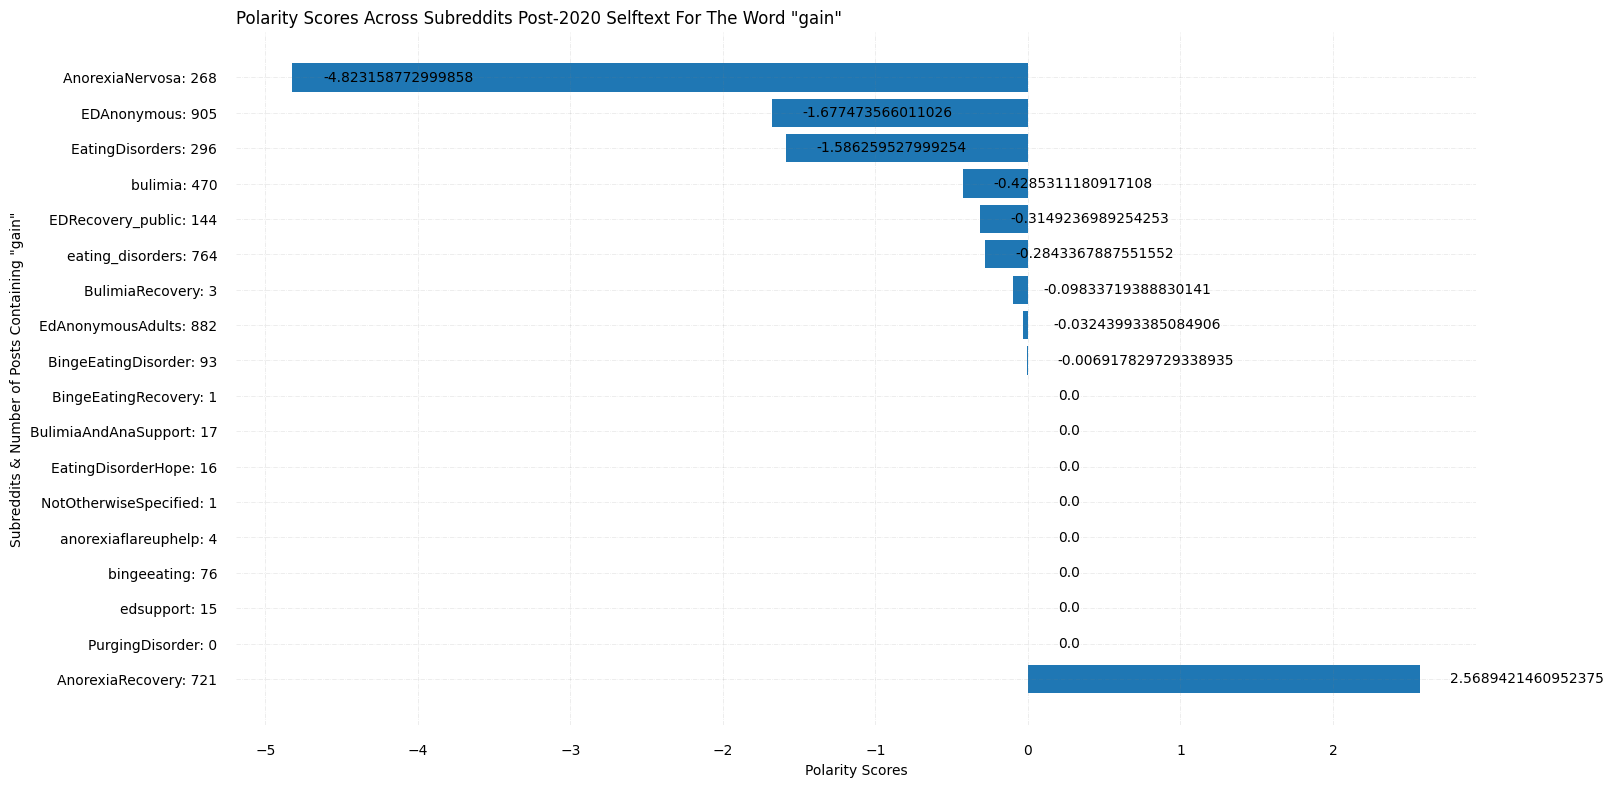

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


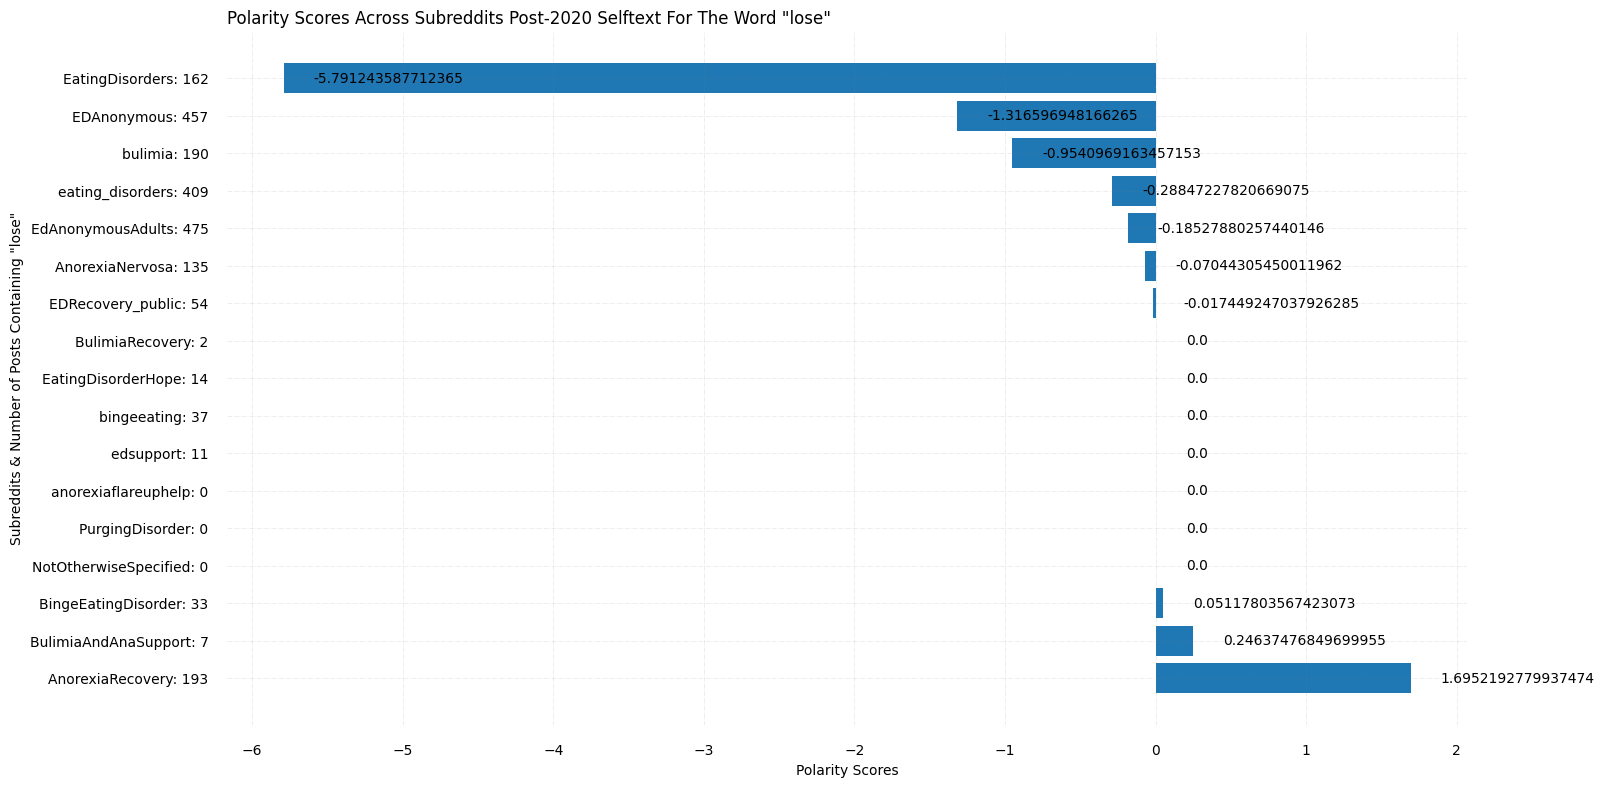

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


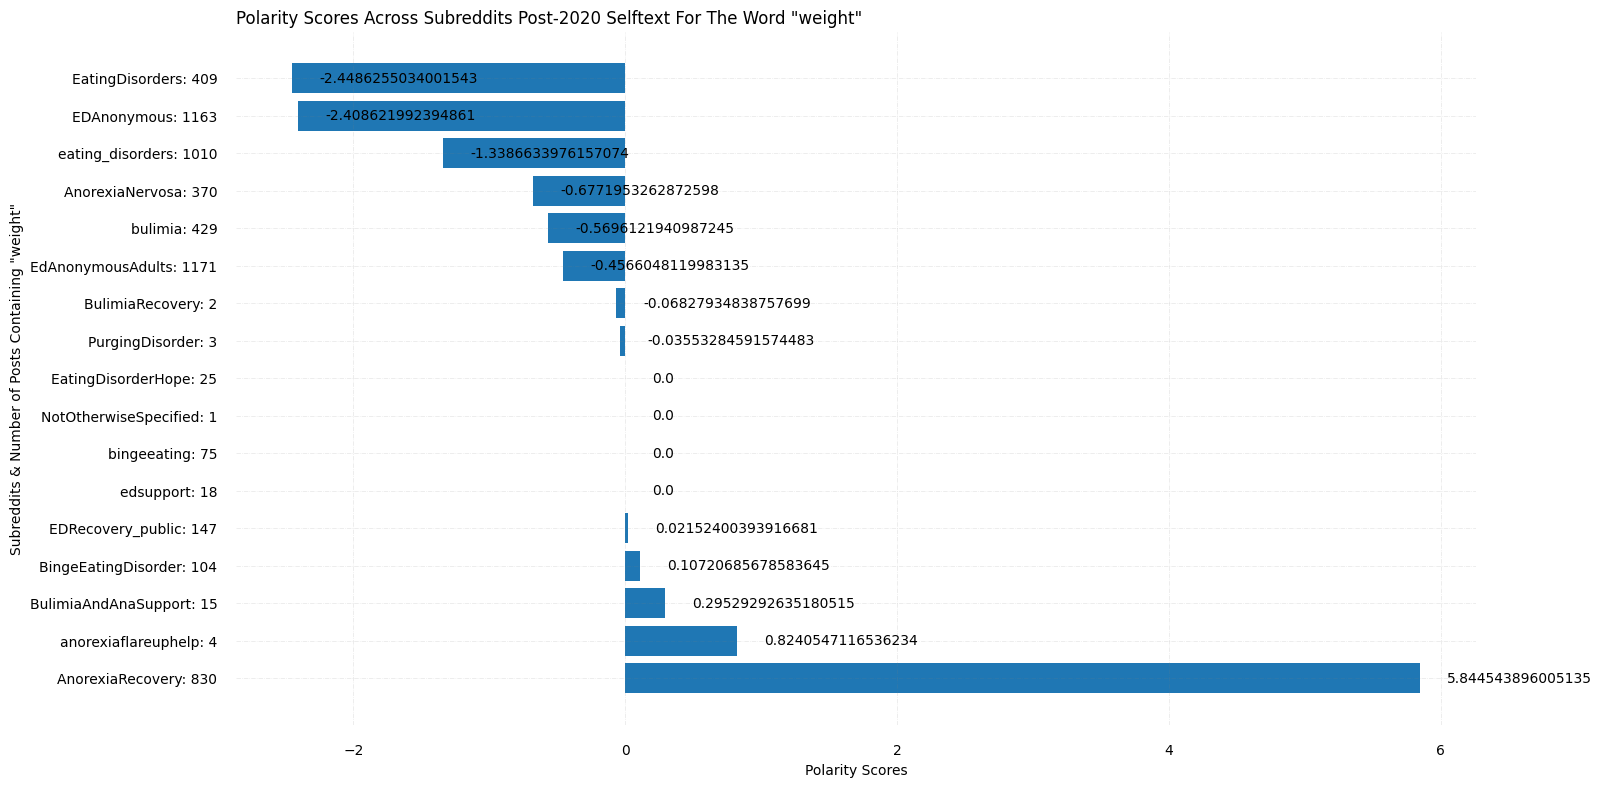

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


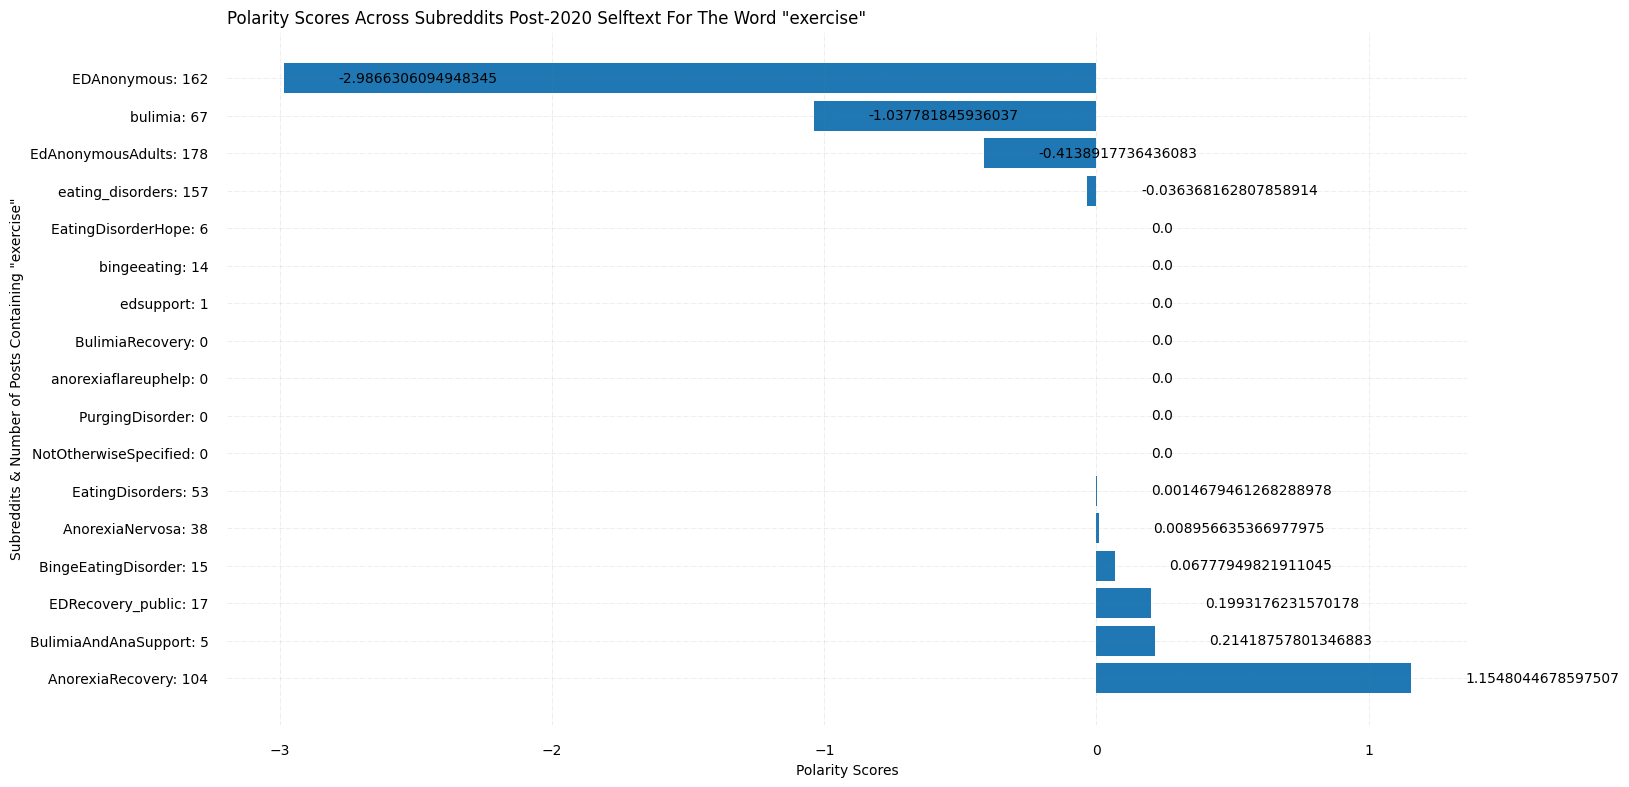

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


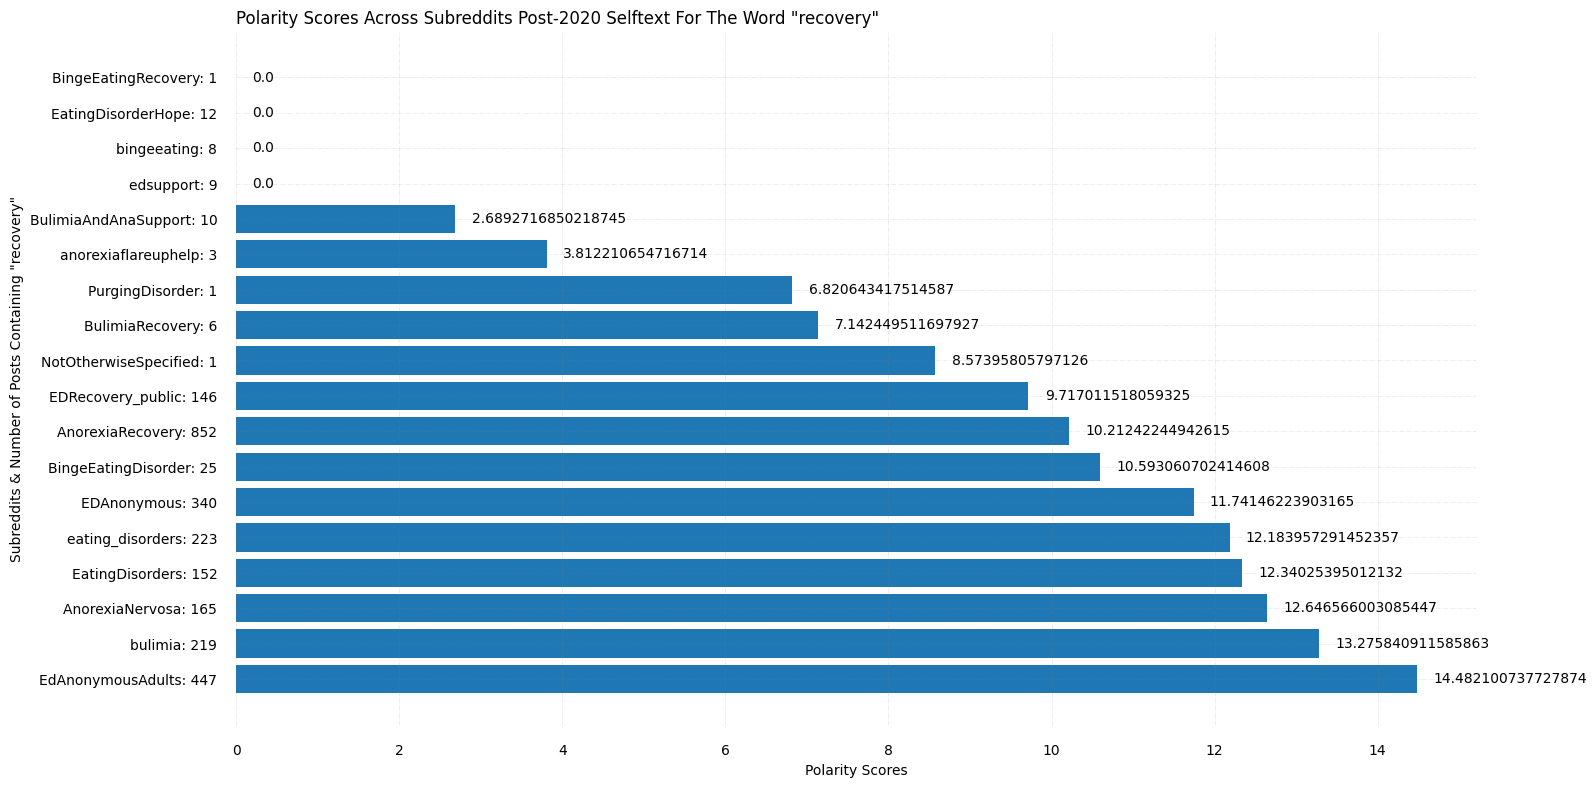

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


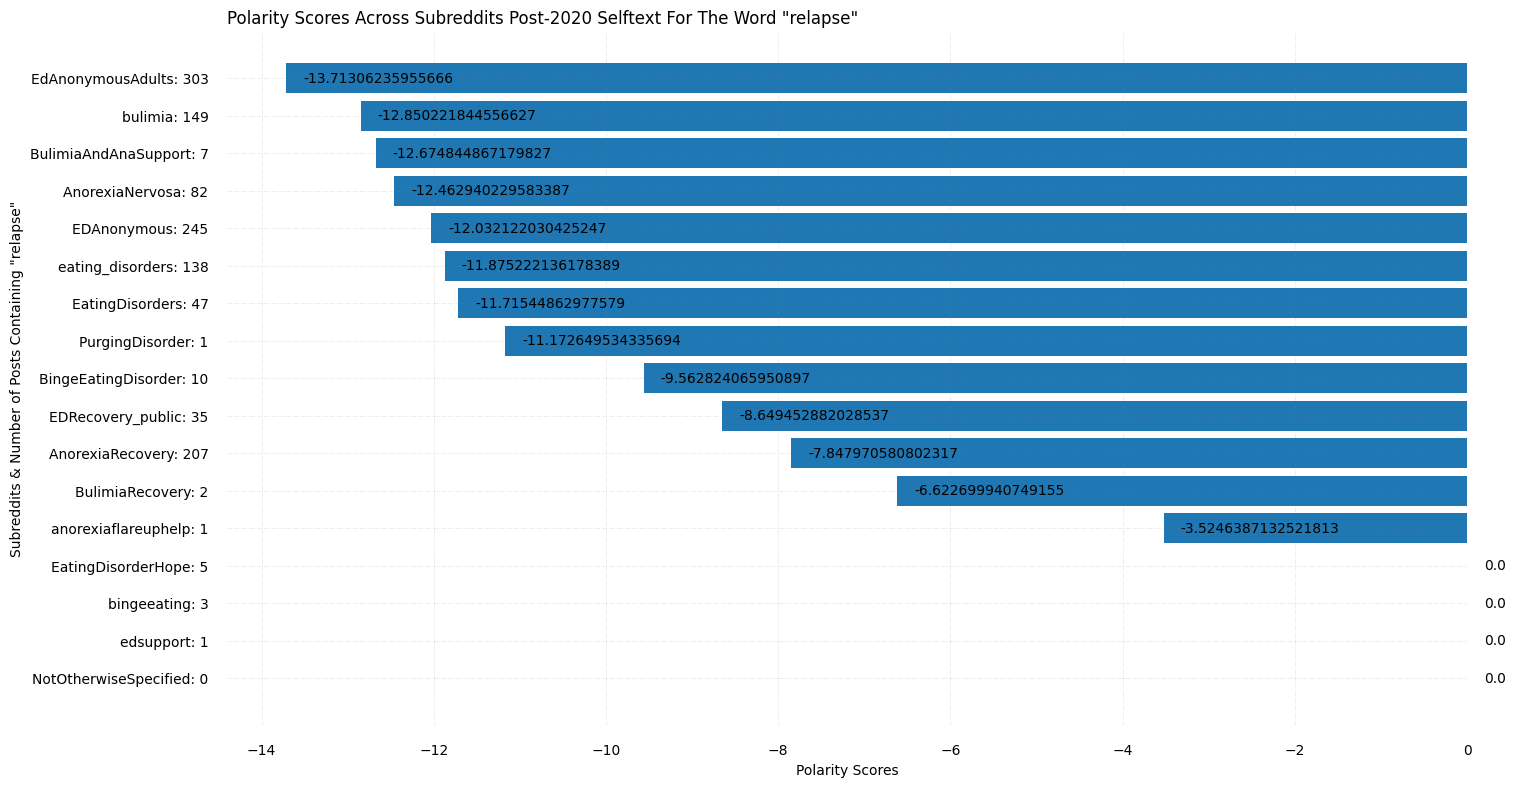

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


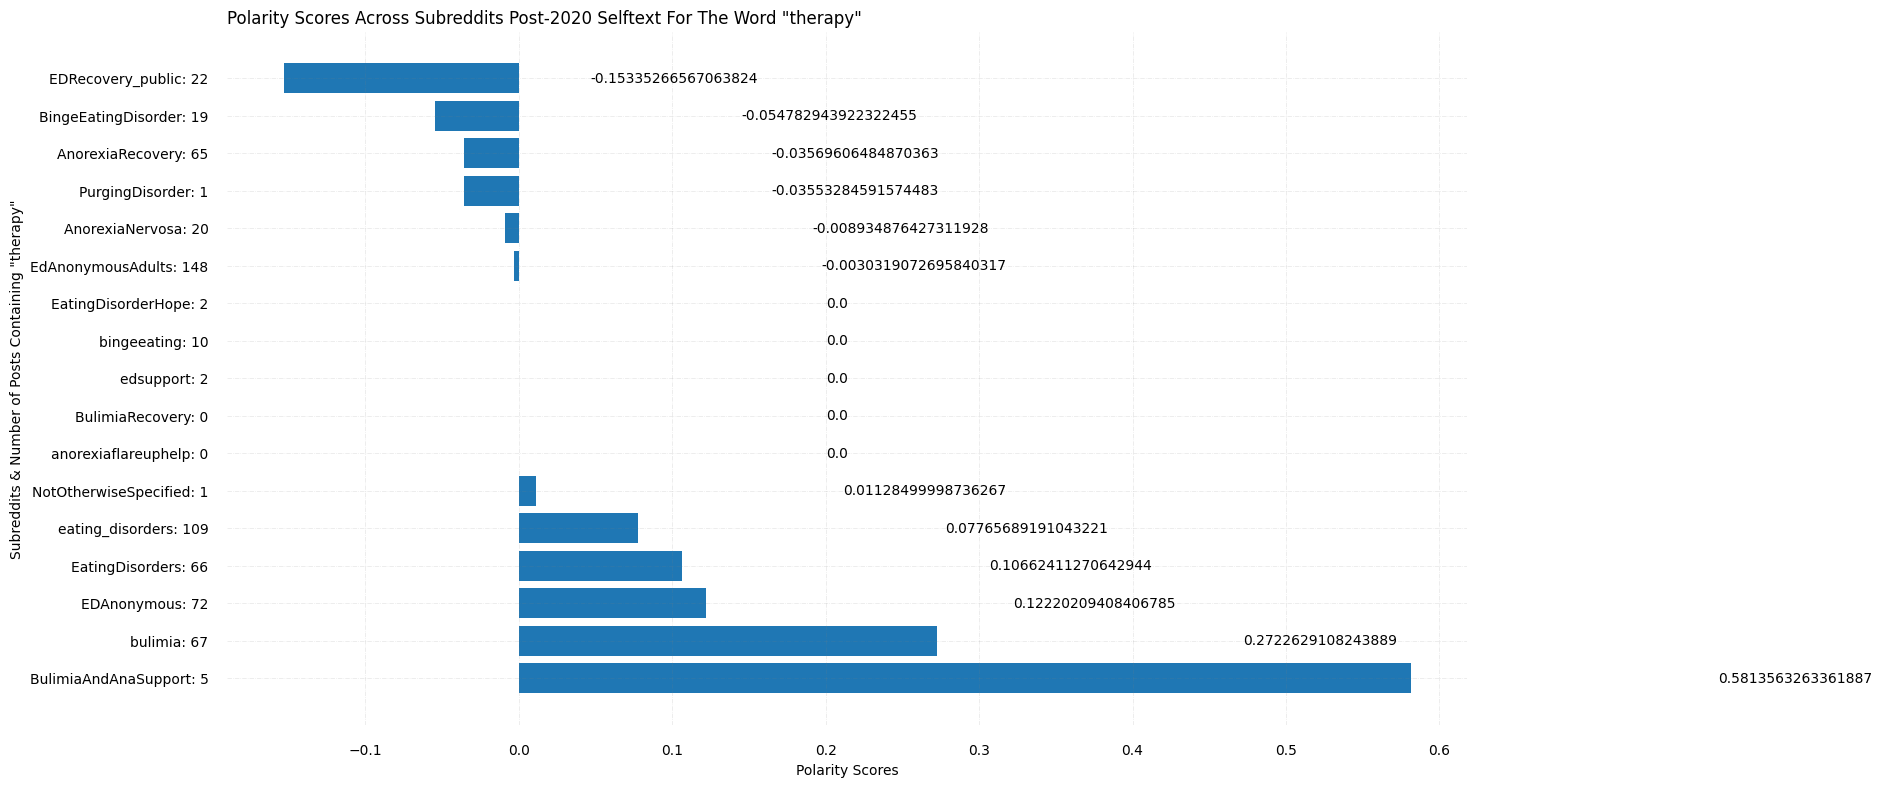

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


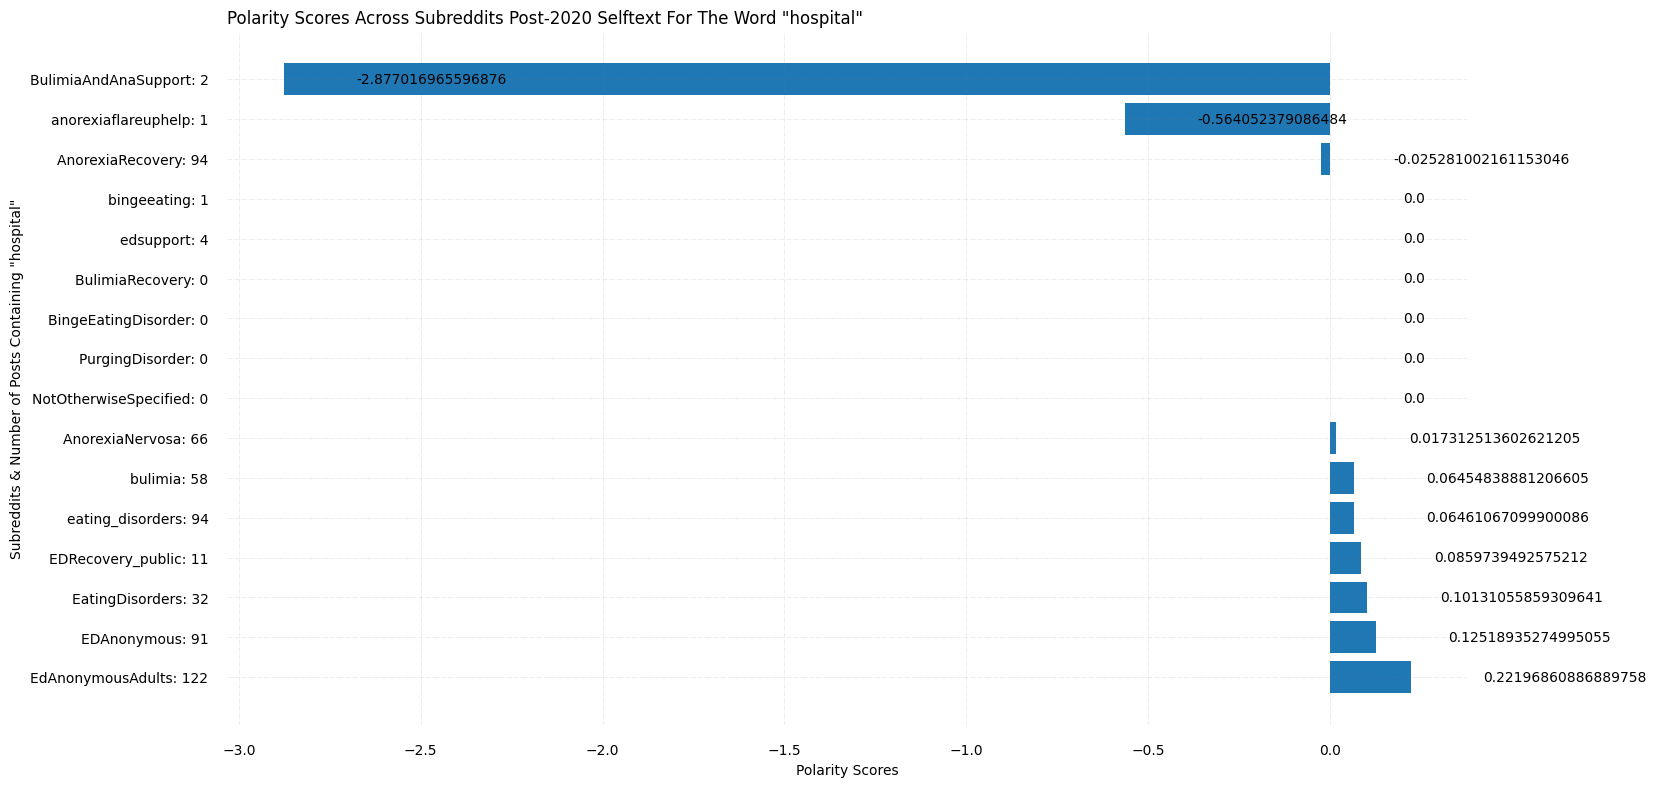

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


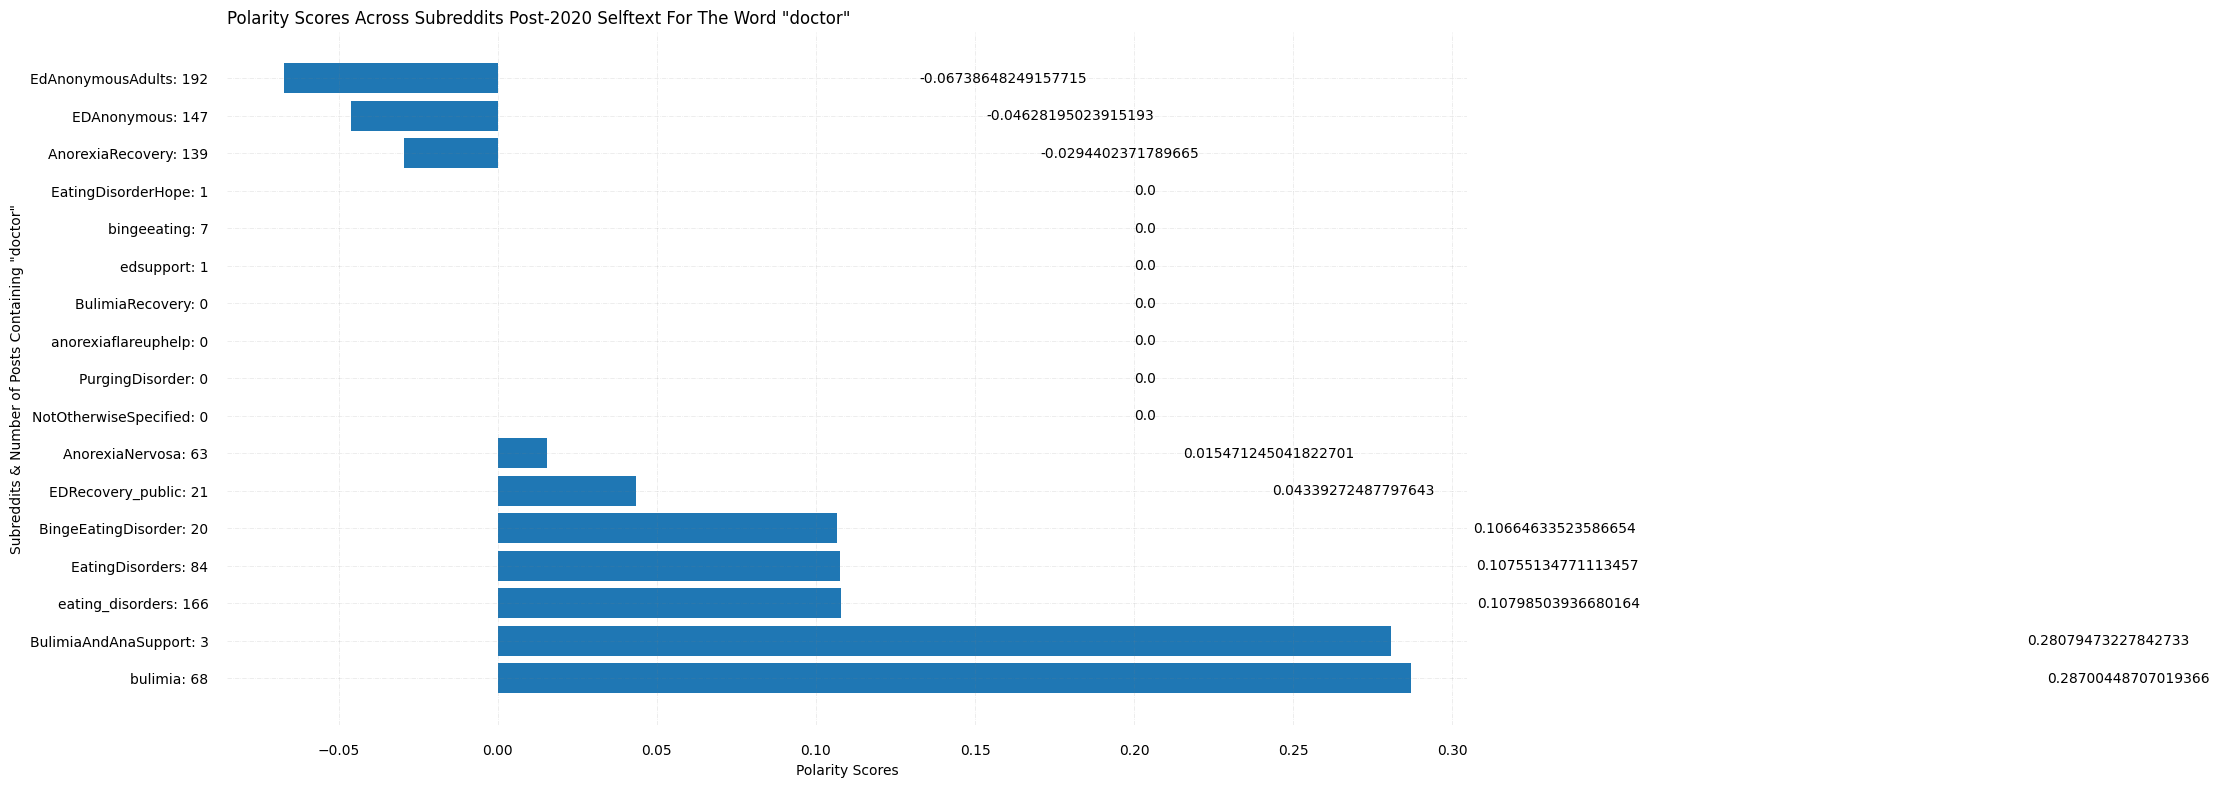

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


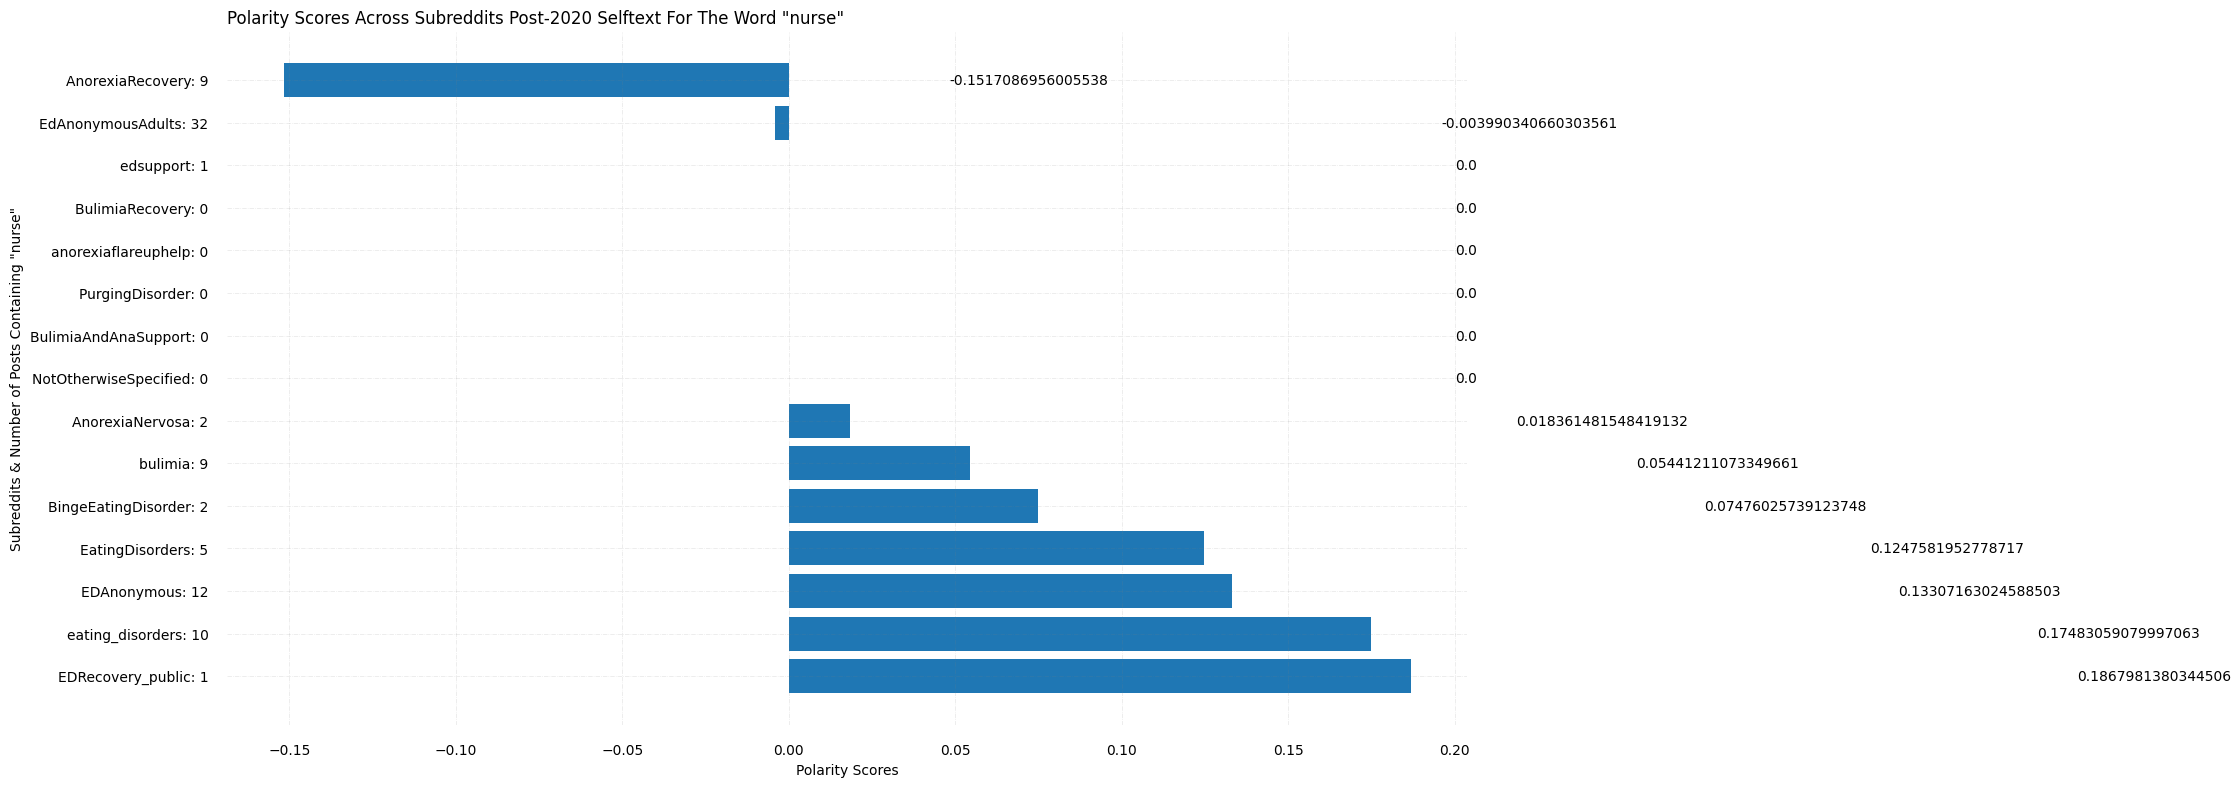

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


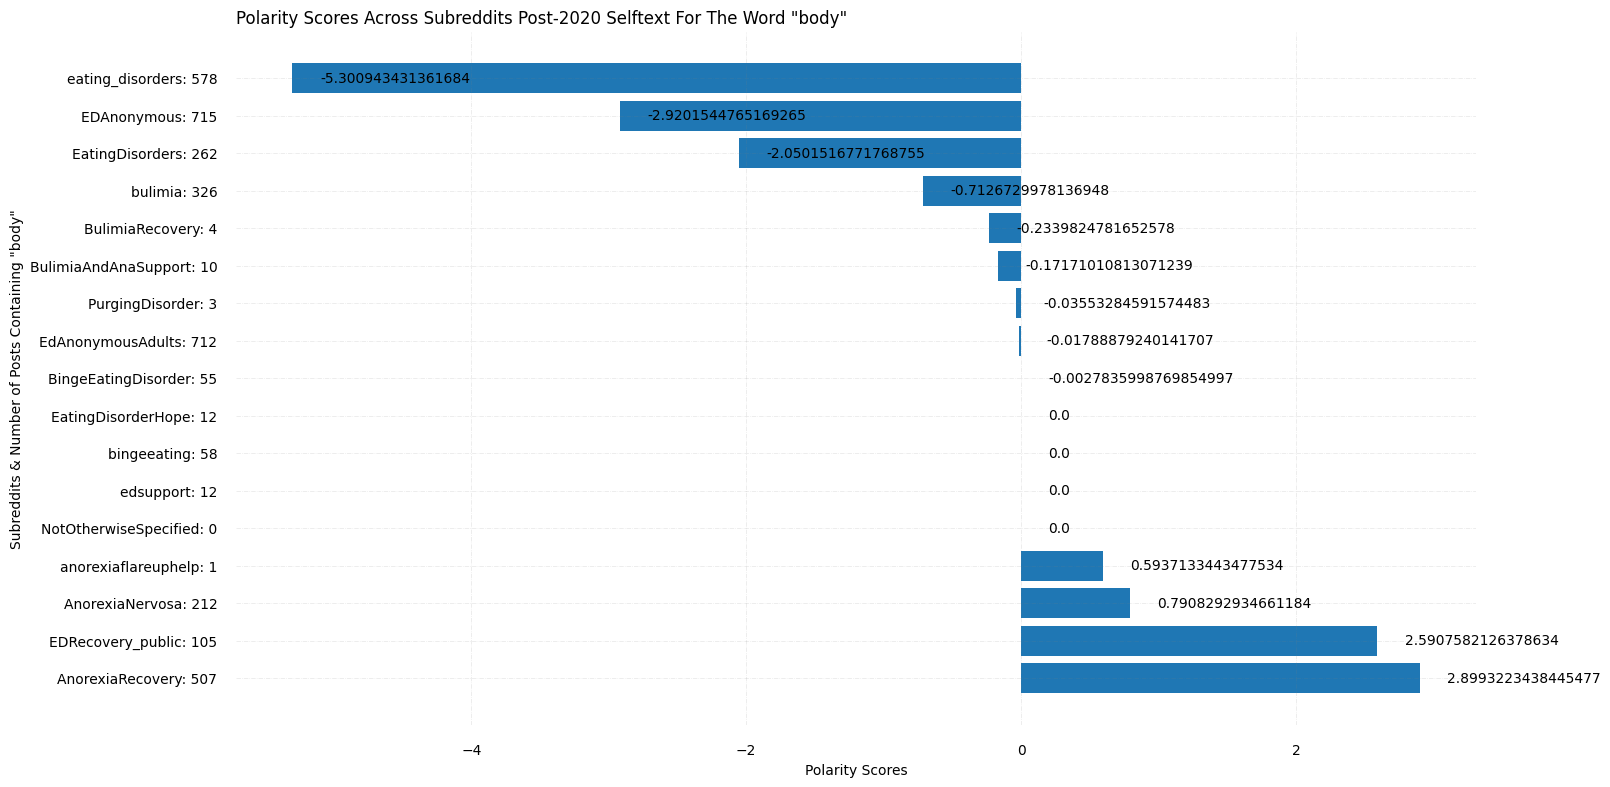

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


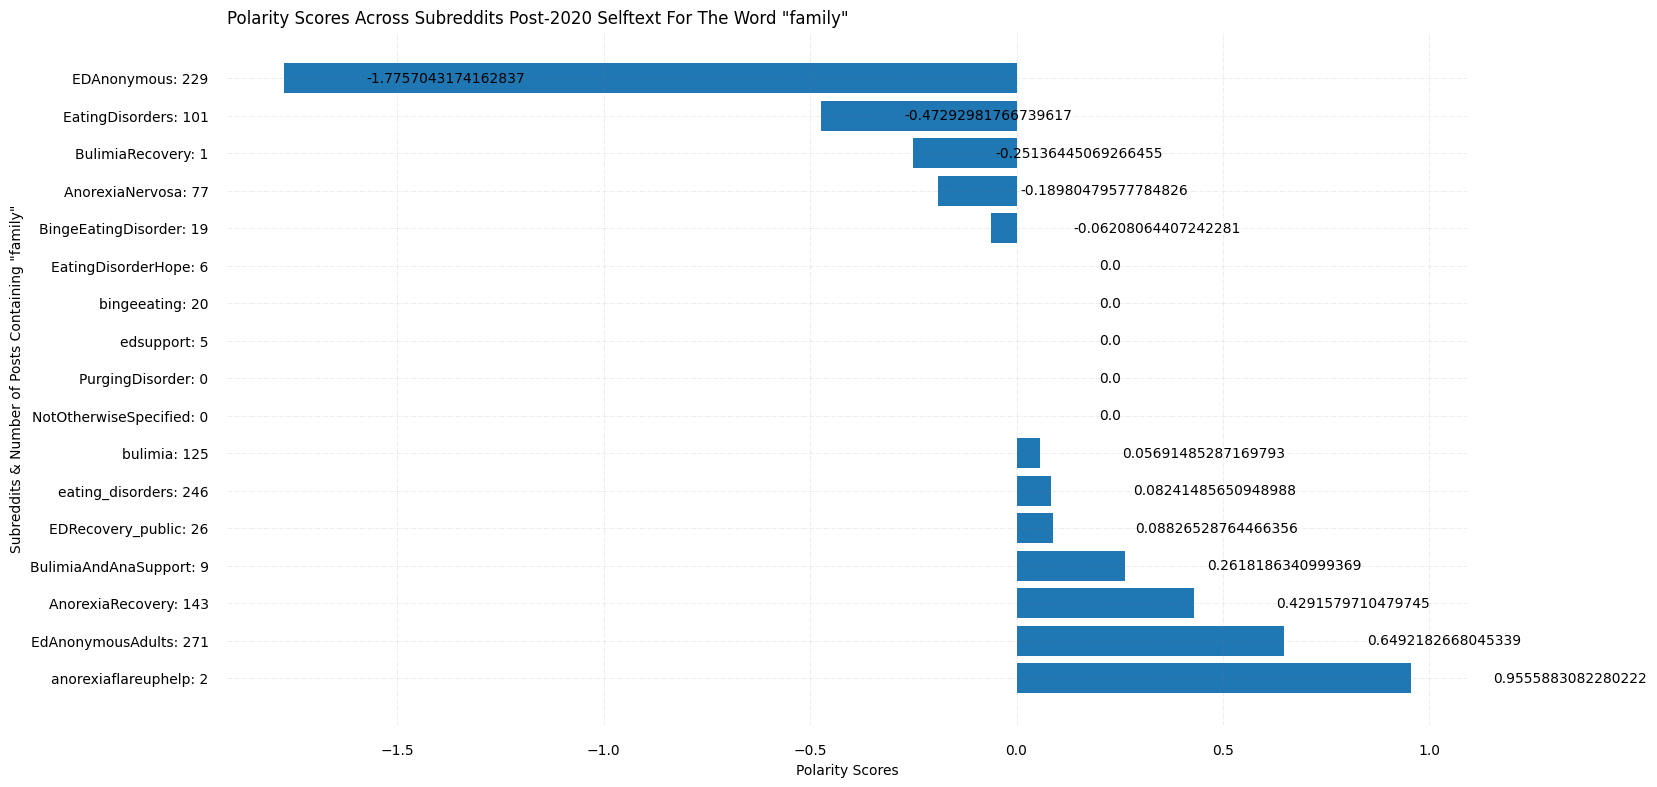

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


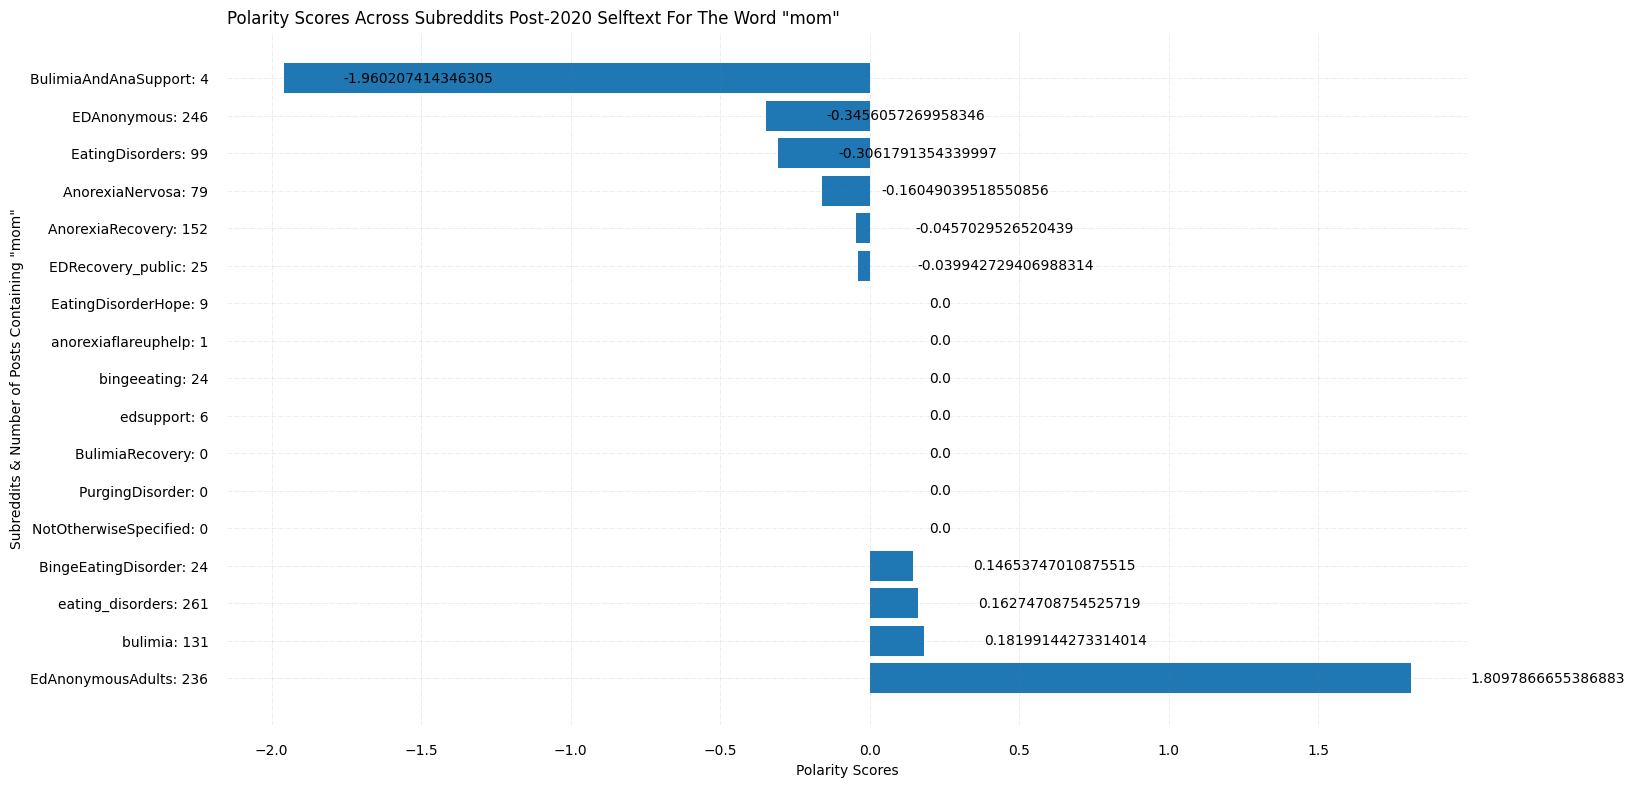

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_62932/364546742.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


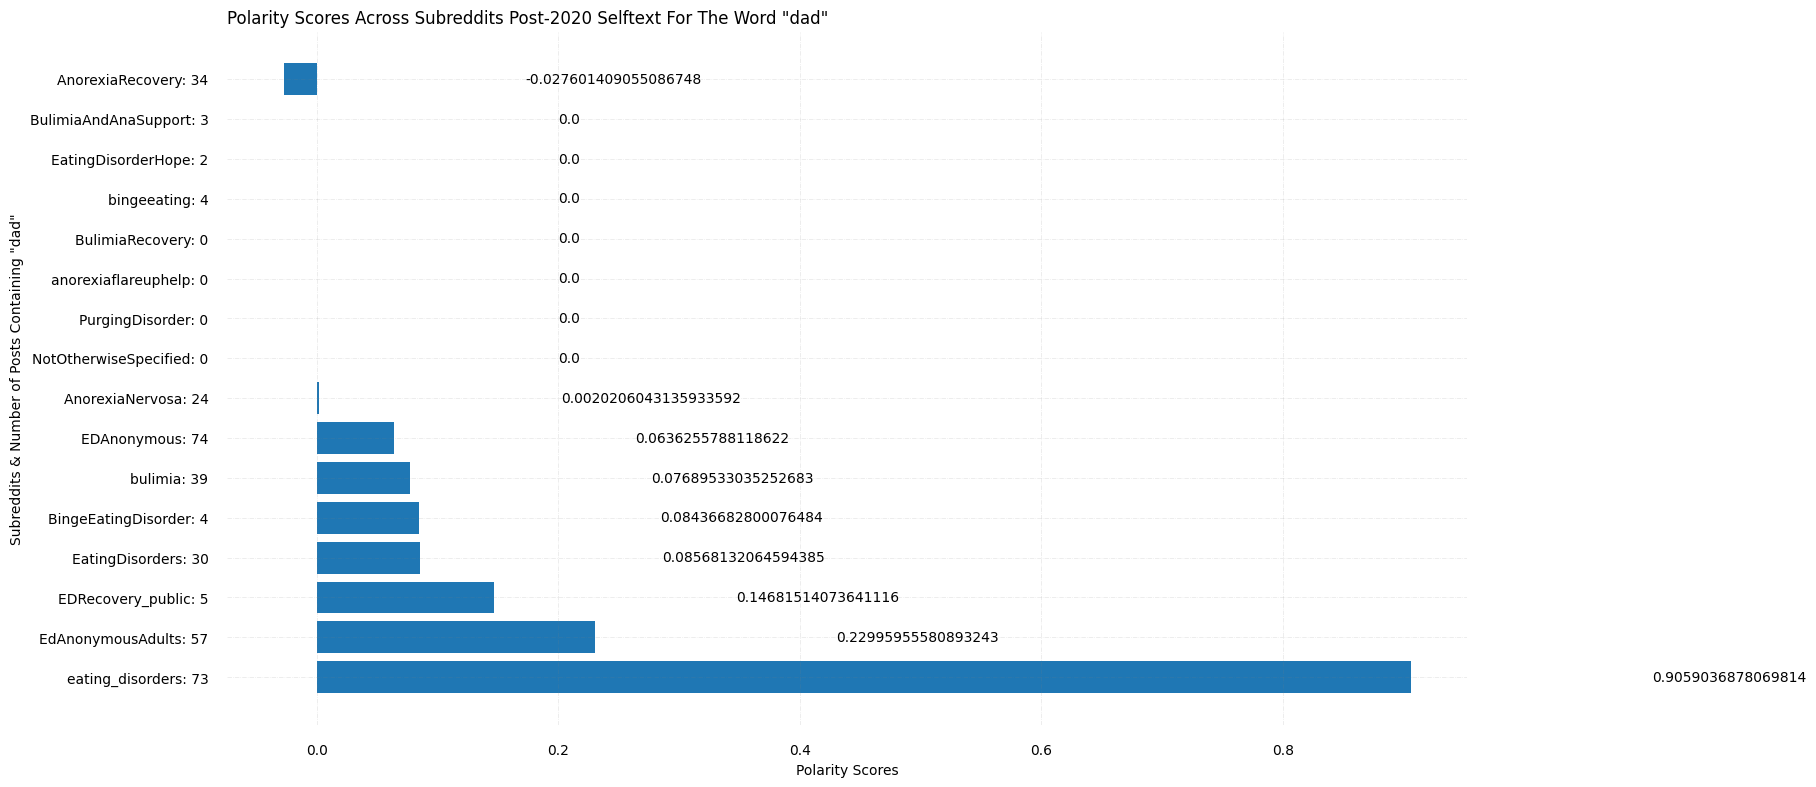

In [34]:
for keyword in keyword_scores.keys():
    subreddits = list(keyword_scores[keyword].keys())
    polarities = list(keyword_scores[keyword].values())

    
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(subreddits, polarities)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(i.get_width()),
                 fontsize = 10,
                 color ='black')

    # Add Plot Title
    ax.set_title(f'Polarity Scores Across Subreddits Post-2020 Selftext For The Word "{keyword}"',
                 loc ='left', )
    plt.ylabel(f'Subreddits & Number of Posts Containing "{keyword}"')
    plt.xlabel("Polarity Scores")

    # Show Plot
    plt.show()


# Submission Polarities

### On submissions from subreddits with posts written post-2020 (so submission polarities using word polarity scores calculated on post-2020 selftext)

In [35]:
# average polarity scores

pre_2020_polarity_dfs = dict()
post_2020_polarity_dfs = dict()

for subreddit in subreddit_polarities.keys():
    try:
        pre_2020 = list()
        post_2020 = list()

        pre_2020_polarities = list()
        post_2020_polarities = list()

        print(subreddit)

        query = f"select id, selftext, created_utc from subreddit_submission_metadata where subreddit='{subreddit}';"
        df = pd.read_sql_query(text(query),con=engine.connect())

        df_ts = list(zip(df['id'].tolist(),df['created_utc'].tolist()))

        for i in df_ts:
            current = datetime.fromtimestamp(i[1])
            if current.year < 2020:
                pre_2020.append(i[0])
            elif current.year > 2020:
                post_2020.append(i[0])

        pre_2020_df = df[df['id'].isin(pre_2020)]
        post_2020_df = df[df['id'].isin(post_2020)]

        for sentence in pre_2020_df.values:
            preprocessed_sentence = lemmatized_preprocess(sentence[1])
            sentence_polarities = [subreddit_polarities[subreddit][word] for word in preprocessed_sentence if word in subreddit_polarities[subreddit].keys()]
            avg_polarities = np.average(sentence_polarities)
            pre_2020_polarities.append({'id':sentence[0], 'selftext':sentence[1],'sentence_polarity':avg_polarities})

        for sentence in post_2020_df.values:
            preprocessed_sentence = lemmatized_preprocess(sentence[1])
            sentence_polarities = [subreddit_polarities[subreddit][word] for word in preprocessed_sentence if word in subreddit_polarities[subreddit].keys()]
            avg_polarities = np.average(sentence_polarities)
            post_2020_polarities.append({'id':sentence[0], 'selftext':sentence[1], 'sentence_polarity':avg_polarities})

        pre_2020_polarity_dfs[subreddit] = pd.DataFrame.from_dict(pre_2020_polarities)
        post_2020_polarity_dfs[subreddit] = pd.DataFrame.from_dict(post_2020_polarities)
    except Exception as e:
        print(e)

AnorexiaRecovery


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


eating_disorders


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EdAnonymousAdults


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


bulimia


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BulimiaRecovery
EDRecovery_public
BingeEatingDisorder


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EatingDisorders
anorexiaflareuphelp
PurgingDisorder
AnorexiaNervosa


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BulimiaAndAnaSupport
EDAnonymous


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NotOtherwiseSpecified


In [36]:
pre_2020_polarity_dfs.keys()

dict_keys(['AnorexiaRecovery', 'eating_disorders', 'EdAnonymousAdults', 'bulimia', 'BulimiaRecovery', 'EDRecovery_public', 'BingeEatingDisorder', 'EatingDisorders', 'anorexiaflareuphelp', 'PurgingDisorder', 'AnorexiaNervosa', 'BulimiaAndAnaSupport', 'EDAnonymous', 'NotOtherwiseSpecified'])

In [37]:
post_2020_polarity_dfs.keys()

dict_keys(['AnorexiaRecovery', 'eating_disorders', 'EdAnonymousAdults', 'bulimia', 'BulimiaRecovery', 'EDRecovery_public', 'BingeEatingDisorder', 'EatingDisorders', 'anorexiaflareuphelp', 'PurgingDisorder', 'AnorexiaNervosa', 'BulimiaAndAnaSupport', 'EDAnonymous', 'NotOtherwiseSpecified'])

In [38]:
for subreddit in pre_2020_polarity_dfs.keys():
#     print(subreddit)
    sub = [subreddit for i in range(len(pre_2020_polarity_dfs[subreddit]))]
    pre_2020_polarity_dfs[subreddit]['subreddit'] = sub

In [39]:
pre_2020_all_v2 = pd.concat([pre_2020_polarity_dfs[subreddit] for subreddit in pre_2020_polarity_dfs.keys()])

In [40]:
pre_2020_all_v2.sort_values(by='sentence_polarity')

subreddit      id  \
12   EdAnonymousAdults  eg2w37   
154  EdAnonymousAdults  dqg2eu   
36    eating_disorders  ec6h62   
63    eating_disorders  e7c0jg   
79    eating_disorders  e4nbi9   
..                 ...     ...   
89   EdAnonymousAdults  e5pxi5   
356  EdAnonymousAdults  b2dd2c   
9     eating_disorders  eg3fq8   
267  EdAnonymousAdults  cjkmxe   
432  EdAnonymousAdults  aonx7a   

                                              selftext  sentence_polarity  
12                                         I loved it.          -7.883701  
154  I just went into hypoglycemic shock. I drank w...          -2.295640  
36   Hi.\n\nMy body feels really bad. REALLY bad.\n...          -2.027898  
63   I barely ate today. Not because I didn’t want ...          -1.927906  
79   I don't know if I have body dysmorphia or I am...          -1.821545  
..                                                 ...                ...  
89                     Someone barfed on my car today.           2.498507  
356                                          Fuck man.           3.720372  
9    On the road to recovery, speaking it into the ...           4.356325  
267                                                  🙍                NaN  
432                                                🤔🤔🤔                NaN  

[997 rows x 4 columns]

In [41]:
for subreddit in post_2020_polarity_dfs.keys():
#     print(subreddit)
    sub = [subreddit for i in range(len(post_2020_polarity_dfs[subreddit]))]
    post_2020_polarity_dfs[subreddit]['subreddit'] = sub

In [42]:
post_2020_all_v2 = pd.concat([post_2020_polarity_dfs[subreddit] for subreddit in post_2020_polarity_dfs.keys()])

In [43]:
post_2020_all_v2.sort_values(by='sentence_polarity')

id                     selftext  sentence_polarity  \
584    znaf5q                i hate myself         -12.430460   
42    10o9fkb                    I hate it         -10.026274   
390   10mmavk  That’s it. That’s the post.          -7.803408   
282   10nisvw    That's it that's the post          -7.803408   
1279  10fxfsl    I hate it. Let’s discuss.          -7.751807   
...       ...                          ...                ...   
1967  10ajqjq                            💖                NaN   
3065  101sqec                            .                NaN   
3316   zznufi                         👨‍🦲💕                NaN   
3368   zz93po                            😀                NaN   
3538   zxoasg                            🌚                NaN   

                subreddit  
584       AnorexiaNervosa  
42    BingeEatingDisorder  
390           EDAnonymous  
282           EDAnonymous  
1279          EDAnonymous  
...                   ...  
1967          EDAnonymous  
3065          EDAnonymous  
3316          EDAnonymous  
3368          EDAnonymous  
3538          EDAnonymous  

[12085 rows x 4 columns]